# Numerical optimization for inverse problems

In this chapter we treat numerical algorithms for solving optimization problems over $\mathbb{R}^n$. Throughout we will assume that the objective $J(u) = D(u) + R(u)$ satisfies the conditions for a unique minimizer to exist. We distinguish between two important classes of problems; *smooth* problems and *convex* problems.

## Smooth optimization

For smooth problems, we assume to have access to as many derivatives of $J$ as we need. As before, we denote the first derivative (or gradient) by $J' : \mathbb{R}^n \rightarrow \mathbb{R}^n$. We denote the second derivative (or Hessian) by $J'' : \mathbb{R}^n \rightarrow \mathbb{R}^{n\times n}$. We will additionally assume that the Hessian is globally bounded, i.e. there exists a constant $L < \infty$ such that $J''(u) \preceq L\cdot I$ for all $u\in\mathbb{R}^n$. Note that this implies that $J'$ is Lipschitz continous with constant $L$: $\|J'(u) - J'(v)\|_2 \leq L \|u - v\|_2$.

For a comprehensive treatment of this topic (and many more), we recommend the seminal book *Numerical Optimization* by Stephen Wright and Jorge Nocedal {cite}`nocedal2006numerical`.

---

Before discussing optimization methods, we first introduce the optimality conditions.

```{admonition} Definition: *Optimality conditions*
:class: important

Given a smooth functional $J:\mathbb{R}^n\rightarrow \mathbb{R}$, a point $u_* \in \mathbb{R}^n$ is local minimizer iff it satisfies the first and second order optimality conditions

$$J'(u_*) = 0, \quad J''(u_*) \succeq 0.$$

If $J''(u_*) \succ 0$ we call $u_*$ a *strict* local minimizer.
```

### Gradient descent

The steepest descent method proceeds to find a minimizer through a fixed-point iteration

$$u_{k+1} = \left(I - \lambda J'\right)(u_k) = u_k - \lambda J'(u_k),$$

where $\lambda > 0$ is the step size. The following theorem states that this iteration will yield a fixed point of $J$, regardless of the initial iterate, provided that we pick $\lambda$ small enough.

````{admonition} Theorem: *Global convergence of steepest descent*
:class: important

Let $J:\mathbb{R}^n\rightarrow \mathbb{R}$ be a smooth, Lipschitz-continuos functional. The fixed point iteration

```{math}
:label: steepest_descent
u_{k+1} = \left(I - \lambda J'\right)(u_k),
```

with $\lambda \in (0,(2L)^{-1})$ produces iterates $u_k$ for which

$$\min_{k\in \{0,1,\ldots, n-1\}} \|J'(u_k)\|_2^2 \leq \frac{J(u_0) - J_*}{C n},$$

with $C = \lambda \left( 1 - \textstyle{\frac{\lambda L}{2}}\right)$ and $J_* = \min_u J(u)$. This implies that $\|J'(u_k)\|_2 \rightarrow 0$ as $k\rightarrow \infty$. To guarantee $\min_{k\in \{0,1,\ldots, n-1\}} \|J'(u_k)\|_2 \leq \epsilon$ we thus need $\mathcal{O}(1/\sqrt{\epsilon})$ iterations.

````

```{admonition} Proof
:class: dropdown, important

Start from a Taylor expansion:

$$J(u_{k+1}) = J(u_k) + J'(u_k)(u_{k+1} - u_k) + \textstyle{\frac{1}{2}}(u_{k+1} - u_k)^T J''(\eta_k)(u_{k+1} - u_k).$$

Now bound the last term using the fact that $J''(u) \preceq L\cdot I$ and plug in $u_{k+1} - u_k = -\lambda J'(u_k)$ to get

$$J(u_{k+1}) - J(u_k) \leq \lambda \left( \textstyle{\frac{\lambda L}{2}} - 1\right) \|J'(u_k)\|_2^2.$$

We conclude that for $0 < \lambda < \textstyle{\frac{1}{2L}}$ we have that $J(u_{k+1}) < J(u_k)$ unless $\|J'(u_k)\|_2 = 0$, in which case $u_k$ is a stationary point. Now, sum over $k$ and re-organise to get

$$\sum_{k=0}^n \|J'(u_k)\|_2^2 \leq \frac{J(u_0) - J(u_n)}{C},$$

with $C = \lambda \left( 1 - \textstyle{\frac{\lambda L}{2}}\right)$. Since $J_* \leq J(u_n)$ we obtain the desired result.
```

Stronger statements about the *rate* of convergence can be made by making additional assumptions on $J$ (such as (strong) convexity), but this is left as an exercise.

### Line search

While the previous results are nice in theory, we usually do not have access to the Lipschitz constant $L$. Moreover, the global bound on the step size provided by the Lipschitz constant may be pessimistic for a particular starting point. This could lead us to pick a very small step size, yielding slow convergence in practice. A popular way of choosing a step size adaptively is a *line search* strategy. To introduce these, we slightly broaden the scope and consider the iteration

$$u_{k+1} = u_k + \lambda_k d_k,$$

where $d_k$ is a *descent direction* satisfying $\langle d_k, J'(u_k)\rangle < 0$. Obviously, $d_k = - J'(u_k)$ is a descent direction, but other choices may be beneficial in practice. In particular, we can choose $d_k = -B J'(u_k)$ for any positive-definite matrix $B$ to obtain a descent direction. How to choose such a matrix will be discussed in the next section.

Two important line search methods are discussed below.

````{admonition} Definition: *Backtracking line search*
:class: important

In order to ensure sufficient progress of the iterations, we can choose a steplength that guarantees sufficient descent:

```{math}
:label: wolfe1
J(u_k + \lambda d_k) \leq J(u_k) + c_1 \lambda \langle d_k, J'(u_k)\rangle,
```

with $c_1 \in (0,1)$ a small constant (typically $c_1 = 10^{-4}$). Existence of a $\lambda$ satisfying these conditions is guaranteed by the regularity of $J$. We can find a suitable $\lambda$ by *backtracking*:

```python
def backtracking(J,Jp,u,d,lmbda,rho=0.5,c1=1e-4)
"""
Backtracking line search to find a step size satisfying J(u + lmbda*d) <= J(u) + lmbda*c1*J(u)^Td

Input:
  J  - Function object returning the value of J at a given input vector
  Jp - Function object returning the gradient of J at a given input vector
  u  - current iterate as array of length n
  d  - descent direction as array of length n
  lmbda - initial step size
  rho,c1 - backtracking parameters, default (0.5,1e-4)

Output:
  lmbda - step size satisfying the sufficient decrease condition
"""
  while J(u + lmbda*d) > J(u) + c*lmbda*Jp(u).dot(d):
    lmbda *= rho
  return lmbda
```
````

````{admonition} Definition: *Wolfe linesearch*
:class: important

A possible disadvantage of the backtracking linesearch introduced earlier is that it may end up choosing very small stepsizes. To obtain a stepsize that yields a new iterate at which the slope of $J$ is not too large, we introduce the following condition

```{math}
:label: wolfe2
|\langle J'(u_k + \lambda d_k), d_k\rangle| \leq c_2 |\langle J'(u_k), d_k\rangle|,
```

where $c_2$ is a small constant satisfying $0 < c_1 < c_2 < 1$. The conditions {eq}`wolfe1` and {eq}`wolfe2`, are referred to as the *strong Wolfe conditions*. Existence of a stepsize satisfying these conditions is again guaranteed by the regularity of $J$ (cf. {cite}`nocedal2006numerical`, lemma 3.1). Finding such a $\lambda$ is a little more involved than the backtracking procedure outlined above (cf. {cite}`nocedal2006numerical`, algorithm 3.5). Luckily, the `SciPy` library provides an implementation of this algorithm (cf. [`scipy.optimize.line_search`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.line_search.html))
````

### Second order methods

A well-known method for root finding is *Newton's method*, which finds a root for which $J'(u) = 0$ via the fixed point iteration

```{math}
:label: newton
u_{k+1} = u_k - J''(u_k)^{-1}J'(u_k).
```

We can interpret this method as finding the new iterate $u_{k+1}$ as the (unique) minimizer of the quadratic approximation of $J$ around $u_k$:

$$J(u) \approx J(u_k) + J'(u_k)(u - u_k) + \textstyle{\frac{1}{2}}\langle u-u_k, J''(u_k)(u-u_k)\rangle.$$

```{admonition} Theorem: *Convergence of Newton's method*
:class: important

Let $J$ be a smooth functional and $u_*$ be a (local) minimizer. For any $u_0$ sufficiently close to $u_*$, the iteration {eq}`newton` converges quadratically to $u_*$, i.e.,

$$\|u_{k+1} - u_*\|_2 \leq M \|u_k - u_*\|_2^2,$$

with $M = 2\|J'''(u_*)\|_2 \|J''(u_*)^{-1}\|_2$.


```
```{admonition} Proof
:class: important, dropdown

See {cite}`nocedal2006numerical`, Thm. 3.5.
```

In practice, the Hessian may not be invertible everywhere and we may not have an initial iterate sufficiently close to a minimizer to ensure convergence. Practical applications therefore include a line search and a safeguard against non-invertible Hessians.

---

In some applications, it may be difficult to compute and invert the Hessian. This problem is addressed by so-called *quasi-Newton* methods which approximate the Hessian. The basis for such approximations is the *secant relation*

$$H_k (u_{k+1} - u_k) = (J'(u_{k+1}) - J'(u_k)),$$

which is satisfied by the true Hessian $J''$ at a point $\eta_k = u_k + t(u_{k+1} - u_k)$ for some $t \in (0,1)$. Obviously, we cannot hope to solve for $H_k \in \mathbb{R}^{n\times n}$ from just these $n$ equations. We can, however, impose some structural assumptions on the Hessian.
Assuming a simple diagonal structure $H_k = h_k I$ yields $h_k = \langle J'(u_{k+1}) - J'(u_k), u_{k+1} - u_k\rangle/\|u_{k+1} - u_k\|_2^2$. In fact, even gradient-descent can be interpreted in this manner by approximating $J''(u_k) \approx L \cdot I$.

---

An often-used approximation is the *Broyden-Fletcher-Goldfarb-Shannon (BFGS)* approximation, which keeps track of the steps $s_k = u_{k+1} - u_k$
and gradients $y_k = J'(u_{k+1}) - J'(u_k)$ to recursively construct an approximation of the *inverse* of the Hessian as

$$B_{k+1} = \left(I - \rho_k s_k y_k^T\right)B_k\left(I - \rho_k y_k s_k^T\right) + \rho_k s_ks_k^T,$$

with $\rho_k = (\langle s_k, y_k\rangle)^{-1}$ and $B_0$ choses appropriately (e.g., $B_0 = L^{-1} \cdot I$). It can be shown that this approximation is sufficiently accurate to yield *super linear* convergence when using a Wolfe line search.

---

The are many practical aspects to implementing such methods. For example, what do we do when the approximated Hessian becomes (almost) singular? Discussing these issues is beyond the scope of these lecture notes and we refer to {cite}`nocedal2006numerical`, chapter 6 for more details. The `SciPy` library provides an implementation of [various optimization methods](https://docs.scipy.org/doc/scipy/reference/optimize.html).

## Convex optimization

In this section, we consider finding a minimizer of a *convex* functional $J : \mathbb{R}^n \rightarrow \mathbb{R}_{\infty}$. Note that we allow the functionals to take values on the extended real line. We accordingly define the domain of $J$ as $\text{dom}(J) = \{u \in \mathbb{R}^n \, | \, J(u) < \infty\}$.

To deal with convex functionals that are not smooth, we first generalize the notion of a derivative.

```{admonition} Definition: subgradient
:class: important

Given a convex functional $J$, we call $g \in \mathbb{R}^n$ a subgradient of $J$ at $u$ if

$$J(v) \geq J(u) + \langle g, v - u\rangle \quad \forall v \in \mathbb{R}^n.$$

This definition is reminiscent of the Taylor expansion and we can indeed easily check that it holds for convex smooth functionals for $g = J'(u)$. For non-smooth functionals there may be multiple vectors $g$ satisfying the inequality. We call the set of all such vectors the *subdifferential* which we will denote as $\partial J(u)$. We will generally denote an arbritary element of $\partial J(u)$ by $J'(u)$.
```

````{admonition} Example: Subdifferentials of some functions

Let

* $J_1(u) = |u|$,
* $J_2(u) = \delta_{[0,1]}(u)$,
* $J_3(u) = \max\{u,0\}$.

All these functions are convex and exhibit a discontinuity in the derivative at $u = 0$. The subdifferentials at $u=0$ are given by

* $\partial J_1(0) = [-1,1]$
* $\partial J_2(0) = (-\infty,0]$
* $\partial J_3(0) = [0,1]$

```{glue:figure} convex_examples
:figwidth: 500px
:name: "convex_examples"

Examples of several convex functions and an element of their subdifferential at $u=0$.
```
````

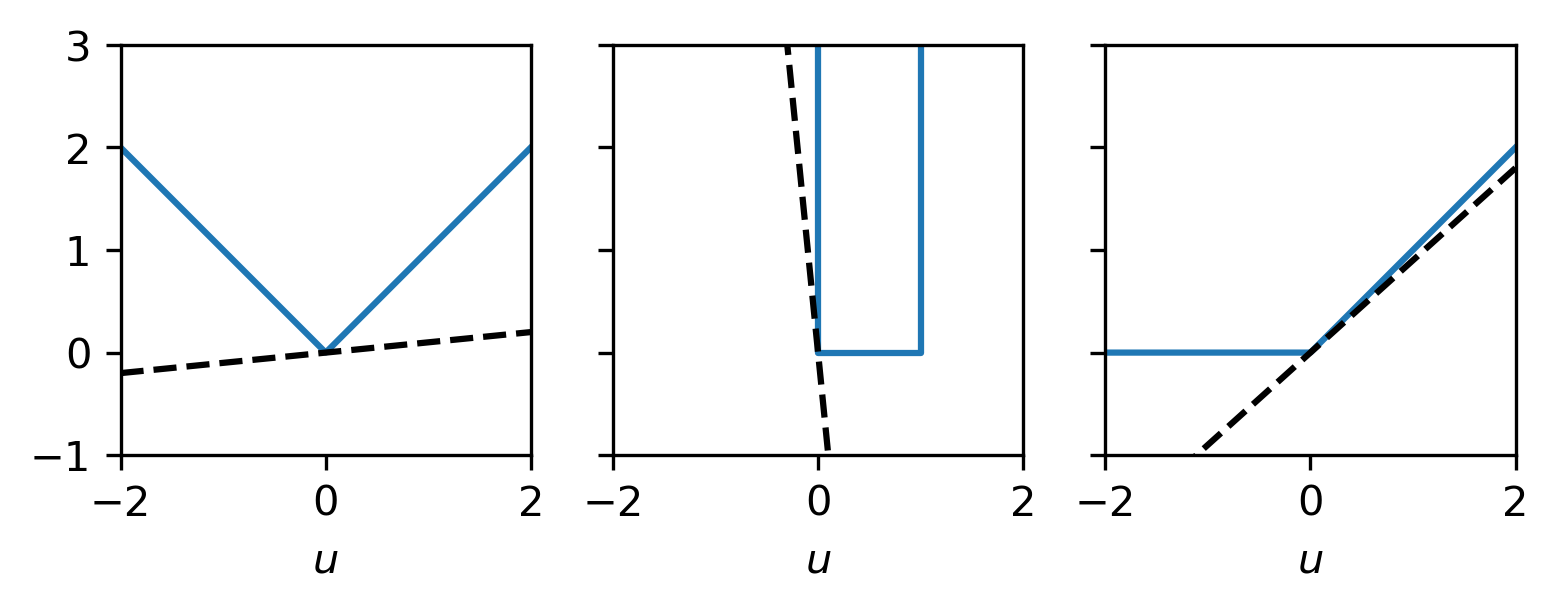

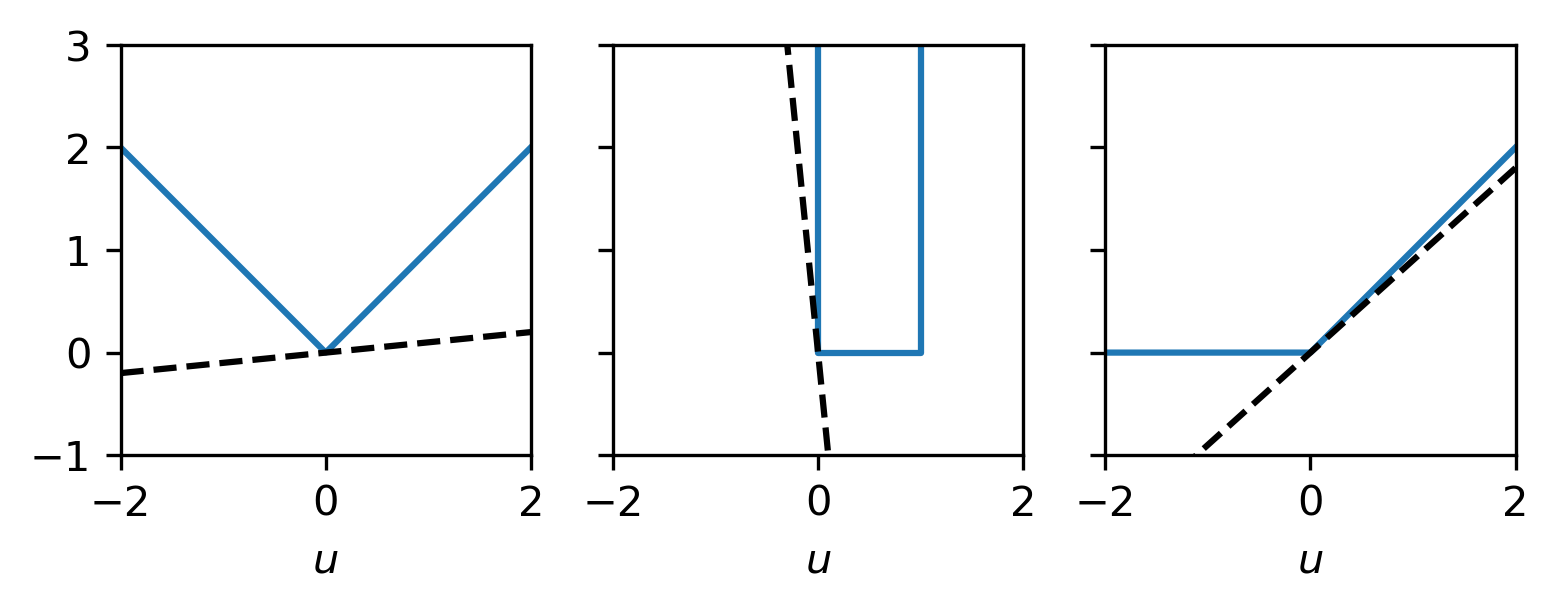

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from myst_nb import glue

#
J1 = lambda u : np.abs(u)
J2 = lambda u : np.piecewise(u, [u<0, u > 1],[lambda u : 1e6, lambda u : 1e6, 0])
J3 = lambda u : np.piecewise(u, [u<0, u > 0],[lambda u : 0, lambda u : u])

#
u = np.linspace(-2,2,1000)

fig, ax = plt.subplots(1,3,sharey=True)

ax[0].plot(u,J1(u))
ax[0].plot(u,.1*u,'k--')
ax[0].set_xlim([-2,2])
ax[0].set_ylim([-1,3])
ax[0].set_aspect(1)
ax[0].set_xlabel(r'$u$')

ax[1].plot(u,J2(u))
ax[1].plot(u,-10*u,'k--')
ax[1].set_xlim([-2,2])
ax[1].set_ylim([-1,3])
ax[1].set_aspect(1)
ax[1].set_xlabel(r'$u$')

ax[2].plot(u,J3(u))
ax[2].plot(u,.9*u,'k--')
ax[2].set_xlim([-2,2])
ax[2].set_ylim([-1,3])
ax[2].set_aspect(1)
ax[2].set_xlabel(r'$u$')

glue("convex_examples",fig)

Some useful calculus rules for subgradients are listed below.

```{admonition} Theorem: Computing subgradients
:class: important

Let $J_i:\mathbb{R}^n \rightarrow \mathbb{R}_{\infty}$ be proper convex functionals and let $A\in\mathbb{R}^{n\times n}$, $b \in \mathbb{R}^n$. We then have the following usefull rules

* *Summation:* Let $J = J_1 + J_2$, then $J_1'(u) + J_2'(u) \in \partial J(u)$ for $u$ in the interior of $\text{dom}(J)$.
* *Affine transformation:* Let $J(u) = J_1(Au + b)$, then $A^T J_1'(Au + b) \in \partial J$ for $u, Au + b$ in the interior of $\text{dom}(J)$.

An overview of other useful relations can be found in e.g., {cite}`Beck2017` section 3.8.
```
---

With this we can now formulate optimality conditions for convex optimization.

```{admonition} Definition: Optimality conditions for convex optimization
:class: important

Let $J:\mathbb{R}^n \rightarrow \mathbb{R}_{\infty}$ be a proper convex functional. A point $u_* \in \mathbb{R}^n$ is a minimizer iff

$$0 \in J'(u_*).$$
```

````{admonition} Example: *Computing the median*

The median $u$ of a set of numbers $(f_1, f_2, \ldots, f_n)$ (with $f_i < f_{i+1}$) is a minimizer of

$$J(u) = \sum_{i=1}^n |u - f_i|.$$

Introducing $J_i = |u - f_i|$ we have

$$J_i'(u) = \begin{cases} -1 & u < f_i \\ [-1,1] & u = f_i \\ 1 & u > f_i\end{cases},$$

with which we can compute $J'(u)$ using the sum-rule:

$$J'(u) = \begin{cases} -n & u < f_1 \\ 2i - n & u \in (f_i,f_{i+1})\\ 2i-1-n+[-1,1] & u = f_i\\n & u> f_n\end{cases}.$$

To find a $u$ for which $0\in J'(u)$ we need to consider the middle two cases. If $n$ is even, we can find an $i$ such that $2i = n$ and get that for all $u \in [f_{n/2},f_{n/2+1}]$ we have $0 \in J'(u)$.
When $n$ is odd, we have optimality only for $u = f_{(n+1)/2}$.

```{glue:figure} median_example
:figwidth: 500px
:name: "median_example"

Subgradient of $J$ for $f=(1,2,3,4)$ and $f=(1,2,3,4,5)$.

```
````

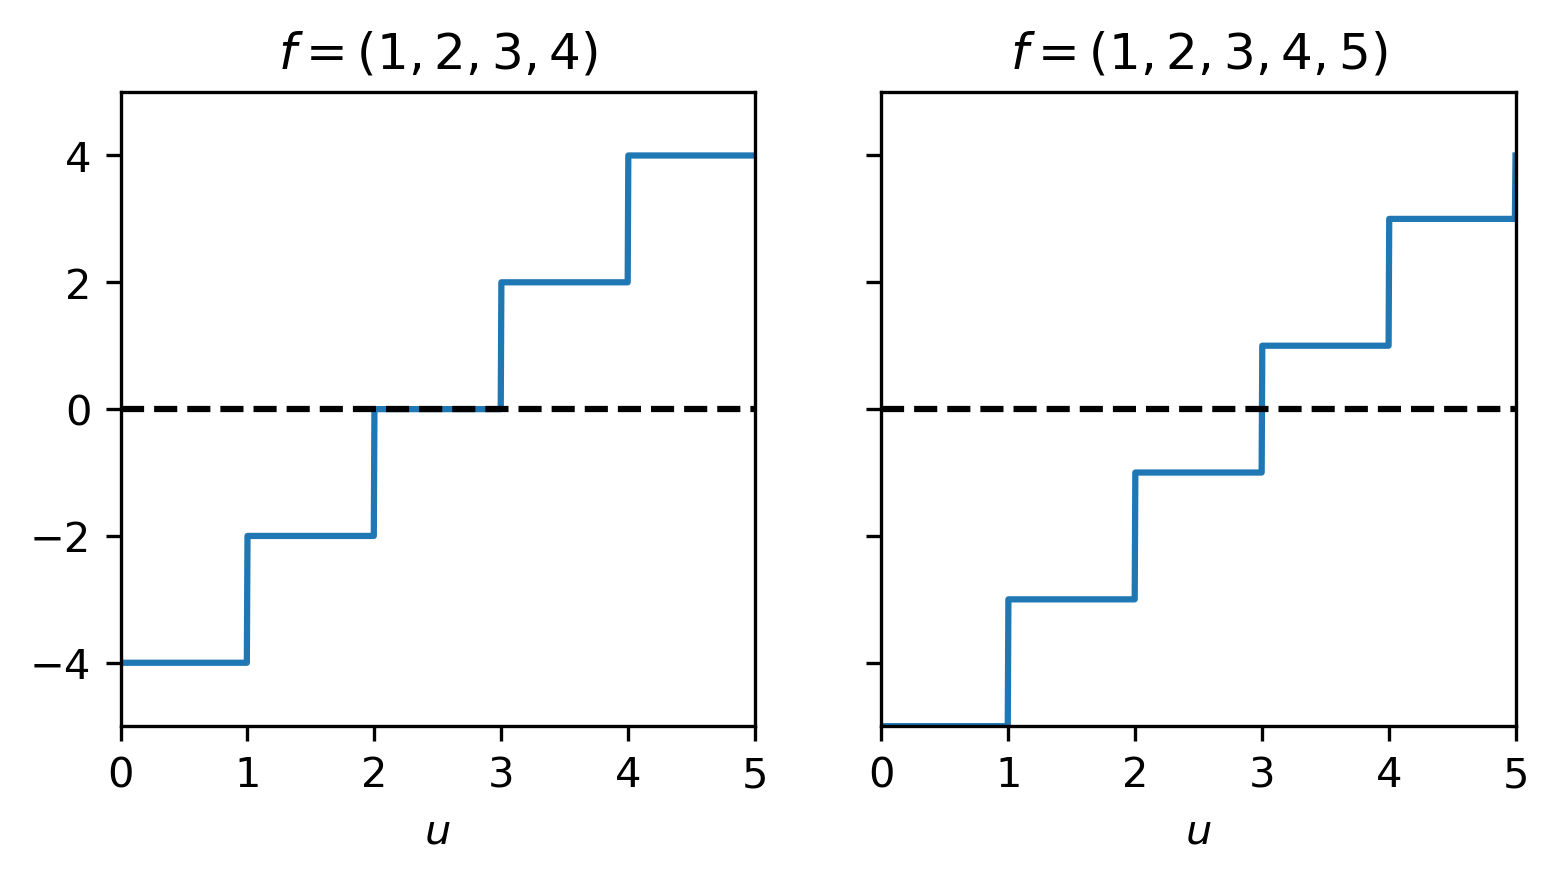

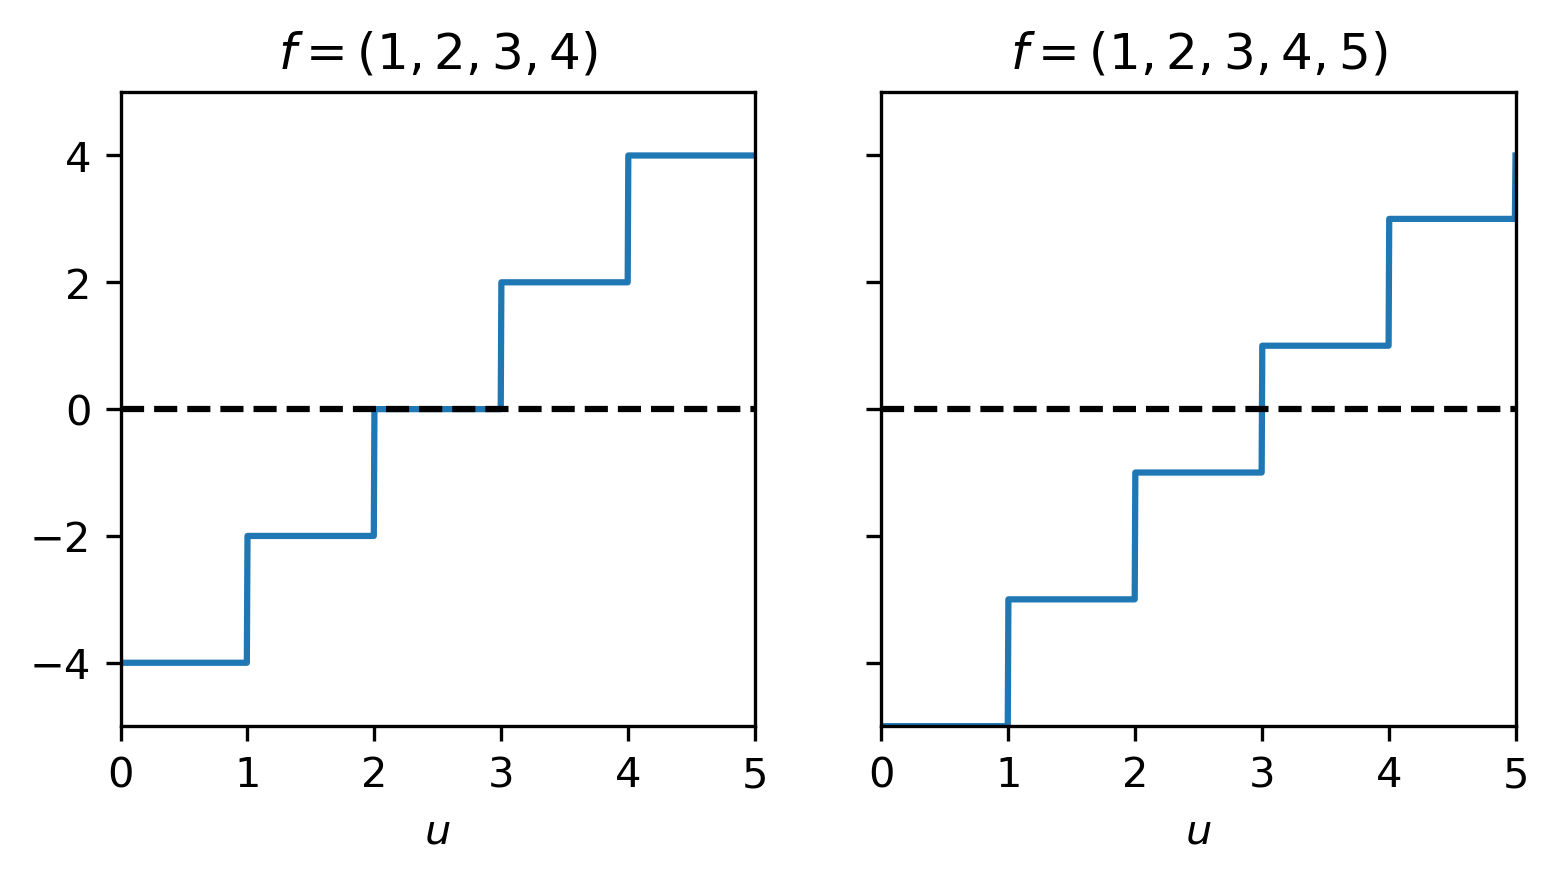

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from myst_nb import glue

#
f1 = np.array([1,2,3,4])
f2 = np.array([1,2,3,4,5])

#
Jip = lambda u,f : np.piecewise(u,[u<f,u==f,u>f],[lambda u : -1, lambda u : 0, lambda u : 1])

def Jp(u,f):
  n = len(f)
  g = np.zeros(u.shape)
  for i in range(n):
    g = g + Jip(u,f[i])
  return g

#
u = np.linspace(0,5,1000)

fig, ax = plt.subplots(1,2,sharey=True)

ax[0].plot(u,Jp(u,f1))
ax[0].plot(u,0*u,'k--')
ax[0].set_xlim([0,5])
ax[0].set_ylim([-5,5])
ax[0].set_xlabel(r'$u$')
ax[0].set_aspect(.5)
ax[0].set_title(r'$f = (1,2,3,4)$')

ax[1].plot(u,Jp(u,f2))
ax[1].plot(u,0*u,'k--')
ax[1].set_xlim([0,5])
ax[1].set_ylim([-5,5])
ax[1].set_xlabel(r'$u$')
ax[1].set_aspect(.5)
ax[1].set_title(r'$f = (1,2,3,4,5)$')

glue("median_example",fig)

### Subgradient descent

A natural extension of the gradient-descent method for smooth problems is the *subgradient descent method*:

```{math}
:label: subgradient_descent
u_{k+1} = u_k - \lambda_k J'(u_k), \quad J'(u_k) \in \partial J(u_k),
```

where $\lambda_k$ denote the step sizes.

```{admonition} Theorem: *Convergence of subgradient descent*
:class: important

Let $J : \mathbb{R}^n \rightarrow \mathbb{R}$ be a convex, $L-$ Lipschitz-continuous function. The iteration {eq}`subgradient_descent` produces iterates for which

$$\min_{k\in\{0,1,\ldots,n-1\}} J(u_k) - J(u_*) \leq \frac{\|u_0 - u_*\|_2^2 + L^2 \sum_{k=0}^{n-1}\lambda_k^2}{2\sum_{k=0}^{n-1}\lambda_k}.$$

Thus, $J(u_k) \rightarrow J(u_*)$ as $k\rightarrow \infty$ when the stepsize satisfy

$$\sum_{k=0}^{\infty} \lambda_k = \infty, \quad \sum_{k=0}^{\infty} \lambda_k^2 < \infty.$$
```

```{admonition} Proof
:class: important, dropdown

First, we expand $\|u_{k+1} - u_*\|_2^2$ by using the definition of $u_{k+1}$:

$$\|u_{k+1} - u_*\|_2^2 = \|u_{k} - \lambda_k J'_k - u_*\|_2^2 = \|u_{k} - u_*\|_2^2 -2 \lambda_k \left \langle J'_k, u_k - u_* \right \rangle + \lambda_k^2\|J'_k\|_2^2. $$

Using the subgradient inequality, we find

$$\|u_{k+1} - u_*\|_2^2 \leq \|u_{k} - u_*\|_2^2 -2 \lambda_k \left(J_k - J_*\right) + \lambda_k^2\|J'_k\|_2^2.$$

Applying this inequality recursively on $u_{k}$ yields

$$0 \leq \|u_{k+1} - u_*\|_2^2 \leq \|u_0 - u_*\|_2^2 -2\sum_{i=0}^k \lambda_i \left(J_i - J_*\right) + \sum_{i=0}^k \lambda_i^2 \|J'_i\|_2^2.$$

Using Lipschitz continuity of $J$, we find $\|J'(u)\|_2 \leq L$ which can be used to yield:

$$ 2 \left(\min_{i\in\{0,1,\ldots,k\}} J(u_i) - J(u_*)\right) \sum_{i=0}^k \lambda_i  \leq 2\sum_{i=0}^k \lambda_i \left(J_i - J_*\right) \leq \|u_0 - u_*\|_2^2 + \sum_{i=0}^k \lambda_i^2 \|J'_i\|_2^2, $$

which can be used to yield the desired result.
```

```{admonition} Remark: *Convergence rate for a fixed stepsize*
If we choose $\lambda_k = \lambda$, we get

$$\min_{k\in\{0,1,\ldots,n-1\}} J(u_k) - J(u_*) \leq \frac{\|u_0 - u_*\|_2^2 + L^2 \lambda^2 n^2}{2\lambda n}.$$

we can guarantee that $\min_{k\in\{0,1,\ldots,n-1\}} J(u_k) - J(u_*) \leq \epsilon$ by picking stepsize $\lambda = \epsilon/L^2$ and doing $n = (\|u_0-u_*\|_2L/\epsilon)^2$ iterations. However, for *smooth* convex functions we derive a stronger result that gradient-descent requires only $\mathcal{O}(1/\epsilon)$ iterations (use exercise 6.4.2, the Lipschitz property, and the subgradient inequality). For smooth *strongly* convex functionals we can strengthen the result even further and show that we only need $\mathcal{O}(\log 1/\epsilon)$ iterations (see exercise 6.4.1). The proofs are left as an exercise.
```

### Proximal gradient methods

While the subgradient descent method is easily implemented, it does not fully exploit the structure of the objective. In particular, we can often split the objective in a *smooth* and a *convex* part. For the discussion we will assume for the moment that

$$J(u) = D(u) + R(u),$$

where $D$ is smooth and $R$ is convex. We are then looking for a point $u_*$ for which

```{math}
:label: diff_inclusion
D'(u_*) \in -\partial R(u_*).
```

Finding such a point can be done (again!) by a fixed-point iteration

$$u_{k+1} = \left(I + \lambda \partial R\right)^{-1}\left(I - \lambda D'\right)(u_k),$$

where $u = \left(I + \lambda \partial R\right)^{-1}(v)$ yields a point $u$ for which $\lambda^{-1}(v - u) \in \partial R(u)$. We can easily show that a fixed point of this iteration indeed solves the differential inclusion problem {eq}`diff_inclusion`. Assuming a fixed point $u_*$, we have

$$u_{*} = \left(I + \lambda \partial R\right)^{-1}\left(I - \lambda D'\right)(u_*),$$

using the definition of $\left(I + \lambda \partial R\right)^{-1}$ this yields

$$\lambda^{-1}\left(u_* - \lambda D'(u_*) - u_*\right) \in \partial R(u_*),$$

which indeed confirms that $-D'(u_*) \in \partial R(u_*)$.

---

```{admonition} Definition: Proximal operator
:class: important
The operator $\left(I + \lambda \partial R\right)^{-1}$ is called the *proximal operator* of $\lambda R$, whose action on input $v$ is implicitly defined as solving

$$\min_u \textstyle{\frac{1}{2}} \|u - v\|_2^2 + \lambda R(u).$$

We usually denote this operator by $\text{prox}_{\lambda R}(v)$.
```

With this, the proximal gradient method for solving {eq}`diff_inclusion` is then denoted as

```{math}
:label: proximal_gradient
u_{k+1} = \text{prox}_{\lambda R}\left(u_k - \lambda D'(u_k)\right).
```

```{admonition} Theorem: *Convergence of the proximal point iteration*
:class: important

Let $J = D + R$ be a functional with $D$ smooth and $R$ convex. Denote the Lipschitz constant of $D'$ by $L_D$. The iterates produced by {eq}`proximal_gradient` with a fixed stepsize $\lambda = 1/L_D$ converge to a fixed point, $u_*$, of {eq}`proximal_gradient`.

If, in addition, $D$ is convex the iterates converges sublinearly to a minimizer $u_*$:

$$J(u_k) - J_* \leq \frac{L_D \|u_* - u_0\|_2^2}{2k}.$$

If $D$ is $\mu$-strongly convex, the iteration converges linearly to a minimizer $u_*$:

$$\|u_{k+1} - u_*\|_2^2 \leq \left(1 - \mu/L_D\right) \|u_{k} - u_*\|_2^2.$$

```
```{admonition} Proof
:class: dropdown, important

We refer to {cite}`Beck2017` Thms. 10.15, 10.21, and 10.29 or more details.
```

---

When compared to the subgradient method, we may expect better performance from the proximal gradient method when $D$ is strongly convex and $R$ is convex. Even if $J$ is smooth, the proximal gradient method may be favorable as the convergence constants depend on the Lipschitz constant of $D$ only; not $J$. All this comes at the cost of solving a minimization problem at each iteration, so these methods are usually only applied when a closed-form expression for the proximal operator exists.

```{admonition} Example: *one-norm*
The proximal operator for the $\ell_1$ norm solves

$$\min_u \textstyle{\frac{1}{2}}\|u - v\|_2 + \lambda \|u\|_1.$$

The solution obeys $u - v \in -\partial \lambda \|u\|_1$, which yields

$$u_i - v_i \in \begin{cases} \{-\lambda\} & u_i > 0 \\ [-\lambda,\lambda] & u_i = 0 \\ \{\lambda\} & u_i < 0\end{cases}$$

This condition is fulfulled by setting

$$u_i = \begin{cases}v_i - \lambda & v_i > \lambda \\ 0 & |v_i|\leq \lambda \\ v_i + \lambda & v_i < -\lambda \end{cases}$$
```

```{admonition} Example: *box constraints*

The Proximal operator of the indicator function of $\delta_{[a,b]^n}$ solves

$$\min_{[a,b]^n} \textstyle{\frac{1}{2}}\|u - v\|_2.$$

The solution is given by

$$u_i = \begin{cases} a & v_i < a \\ v_i & v_i \in [a,b] \\ b & v_i > b\end{cases}.$$

Thus, $u$ is an orthogonal projection of $v$ on $[a,b]^n$.
```

### Splitting methods

The proximal point methods require that the proximal operator for $R$ can be evaluated efficiently. In many practical applications this is not the cases, however. Instead, we may have a regularizer of the form $R(Au)$ for some linear operator $A$. Even when $R(\cdot)$ admits an efficient proximal operator $R(A\cdot)$ will, in general, not. In this section we discuss a class of methods that allow us to shift the operator $A$ to the other part of the objective. As a model-problem we will consider solving

$$\min_{u\in \mathbb{R}^n} D(u) + R(Au),$$

with $D$ smooth and convex, $R(\cdot)$ convex and $A \in \mathbb{R}^{m\times n}$ a linear map. The basic idea is to introduce an auxiliary variable $v$ and re-formulate the variational problem as

```{math}
:label: splitted
\min_{u\in \mathbb{R}^n,v\in\mathbb{R}^m} D(u) + R(v), \quad \text{s.t.} \quad Au = v.
```

To solve such constrained optimization problems we employ the method of Lagrange multipliers which defines the *Lagrangian*

$$\Lambda(u,v,\nu) = D(u) + R(v) + \langle \nu, Au - v\rangle,$$

where $\nu \in \mathbb{R}^m$ are called the Lagrange multipliers. The solution to {eq}`splitted` is a saddle point of $\Lambda$ and we can thus be obtained by solving

```{math}
:label: saddle_point
\min_{u,v} \max_{\nu} \Lambda(u,v,\nu).
```

The equivalence between {eq}`splitted` and {eq}`saddle_point` is established in the following theorem

```{admonition} Theorem: *Saddle point theorem*
:class: important

Let $(u_*,v_*)$ be a solution to {eq}`splitted`, then there exists a $\nu^*\in\mathbb{R}^m$ such that $(u_*,v_*,\nu_*)$ is a saddle point of $\Lambda$ and vice versa.
```

```{admonition} Proof
:class: important, dropdown

see [these notes](https://sites.math.washington.edu/~burke/crs/516/notes/saddlepoints.pdf)
```

Another important concept related to the Lagrangian is the *dual problem*.

````{admonition} Definition: *Dual problem*
:class: important

The dual problem related to {eq}`saddle_point` is

```{math}
:label: dual_saddle_point
\max_{\nu} \min_{u,v} \Lambda(u,v,\nu).
```
````

For convex problems, the primal and dual problems are equivalent, giving us freedom when designing algorithms.

```{admonition} Theorem: *Strong duality*
The primal {eq}`saddle_point` and dual {eq}`dual_saddle_point` are equivalent in the sense that

$$ \min_{u,v} \max_{\nu} \Lambda(u,v,\nu) = \max_{\nu} \min_{u,v} \Lambda(u,v,\nu).$$
```

```{admonition} Proof
:class: important, dropdown

see [these notes](https://sites.math.washington.edu/~burke/crs/516/notes/saddlepoints.pdf)
```

```{admonition} Example: TV-denoising

The TV-denoising problem can be expressed as

$$\min_{\mathbb{R}^n} \textstyle{\frac{1}{2}} \|u - f^\delta\|_2^2 + \lambda \|Du\|_1,$$

with $D \in \mathbb{R}^{m \times n}$ a discretisation of the first derivative. We can express the corresponding dual problem as

$$\max_{\nu} \min_u \textstyle{\frac{1}{2}} \|u - f^\delta\|_2^2 + \langle \nu,Du\rangle + \min_v \lambda \|v\|_1 - \langle \nu, v\rangle.$$

The first term is minimised by setting $u = f^\delta - D^*\nu$. The second term is a bit trickier. First, we note that $\lambda \|v\|_1 - \langle \nu, v\rangle$ is not bounded from below when $\|\nu\|_{\infty} > \lambda$. Furthermore, for $\|\nu\|_{\infty} \leq \lambda$ it attains a minimum for $v = 0$.

This leads to

$$\max_{\nu} -\textstyle{\frac{1}{2}} \|D^*\nu\|_2^2 + \langle D^*\nu, f^\delta\rangle - \delta_{\|\cdot\|_\infty \leq \lambda}(\nu),$$

which is a constrained quadratic program. Since the first part is smooth and the proximal operator for the constraint $\|\nu\|_{\infty} \leq \lambda$ is easy we can employ a proximal gradient method to solve the dual problem. Having solved it, we can retrieve the primary variable via the relation $u = f^\delta - D^*\nu$.
```

The strategy illustrated in the previous approach is an example of a more general approach to solving problems of form {eq}`splitted`.

```{admonition} *Dual-based proximal gradient*
:class: important

We start from the dual problem {eq}`dual_saddle_point`:

$$\max_{\nu} \left(\min_u \left( D(u) + \langle Au,\nu \rangle \right) \right) + \left(\min_v \left( R(v) - \langle \nu, v\rangle \right) \right).$$

In this expression we recognise the [*convex conjugates*](https://en.wikipedia.org/wiki/Convex_conjugate) of $D$ and $R$. With this, we re-write the problem as

$$\min_{\nu} D^*(-A^T\nu) + R^*(\nu).$$

Thus, we have moved the linear map to the other side. We can now apply the proximal gradient method provided that:

* We have a closed-form expression for the convex conjugates of $D$ and $R$;
* $R^*$ has a proximal operator that is easily evaluated.

For many simple functions, we do have such closed-form expressions of their convex conjugates. Moreover, to compute the proximal operator, we can use *Moreau's identity:* $\text{prox}_{R}(u) + \text{prox}_{R^*}(u) = u$.
```

---

It may not always be feasible to formulate the dual problem explicitly as in the previous example. In such cases we would rather solve {eq}`dual_saddle_point` directly. A popular way of doing this is the *Alternating Direction of Multipliers Method*.

```{admonition} *Alternating Direction of Multipliers Method (ADMM)*
:class: important

We augment the Lagrangian by adding a quadratic term:

$$\Lambda_{\rho}(u,v,\nu) = D(u) + R(v) + \langle\nu,Au - v\rangle + \textstyle{\frac{\rho}{2}} \|Au - v\|_2^2.$$

We then find the solution by updating the variables in an alternating fashion

$$u_{k+1} = \text{arg}\min_{u} \Lambda_{\rho}(u,v_k,\nu_k),$$
$$v_{k+1} = \text{arg}\min_{v} \Lambda_{\rho}(u_{k+1},v,\nu_k),$$
$$\nu_{k+1} = \nu_k + \rho(Au_{k+1} - v_{k+1}).$$

Efficient implementations of this method rely on the proximal operators of $D$ and $R$.
```

```{admonition} Example:*TV-denoising*
Consider the TV-denoising problem from the previous example.

The ADMM method find a solution via

$$u_{k+1} = \left(I + \rho D^*\!D\right)^{-1}\left(f^\delta + D^*(\rho v_k - \nu_k)\right).$$
$$v_{k+1} = \text{prox}_{(\lambda/\rho)\|\cdot\|_1}\left(Du_{k+1} + \rho^{-1}\nu_k\right).$$
$$\nu_{k+1}= \nu_k + \rho \left(Du_{k+1} - v_{k+1}\right).$$
```

---

We cannot do justice to the breadth and depth of the topics smooth and convex optimization in one chapter. Rather, we hope that this chapter serves as a starting point for further study in one of these areas for some, and provides useful recipes for others.

## Exercises

### Steepest descent for strongly convex functionals

Consider the following fixed point iteration for minimizing a given function $J : \mathbb{R}^n \rightarrow \mathbb{R}$

$$
u^{(k+1)} = u^{(k)} - \alpha J'(u^{(k)}),
$$

where $J$ is twice continuously differentiable and strictly convex:

$$
\mu I \preceq J''(u) \preceq L I,
$$

with $0 < \mu < L < \infty$.

* Show that the fixed point iteration converges linearly, i.e.,
$\|u^{(k+1)} - u^*\| \leq \rho \|u^{(k)} - u*\|$ with $\rho < 1$, for $0 < \alpha < 2/L$.

```{admonition} Answer
:class: tip, dropdown

[Linear convergence](https://en.wikipedia.org/wiki/Rate_of_convergence#Basic_definition) implies that $\exists 0 < \rho < 1$ such that

$$\|u^{(k+1)} - u^*\| \leq \rho \|u^{(k)} - u*\|,$$

where $u^*$. To show this we start from the iteration and substract the fixed-point and use that $J'(u^*) = 0$ to get

$$(u^{(k+1)} - u^*) = (u^{(k)} - u^*) - \alpha (J'(u^{(k)}) - J'(u^*)).$$

Next use Taylor to express

$$J'(u^{(k)}) - J'(u^*) = J''(\eta^{(k)}) (u^{(k)} - u^*),$$

with $\eta^{(k)} = t u^{(k)} + (1-t)u^*$ for some $t \in [0,1]$. We then get

$$\|u^{(k+1)} - u^*\|_2 \leq \|I - \alpha J''(\eta^{(k)})\|_2 \|u^{(k)} - u^*\|_2.$$

For linear convergence we need $\|I - \alpha J''(\eta^{(k)})\|_2 < 1$. We use that $\|A\|_2 = \sigma_{\max}(A)$. (cf. [Matrix norms](https://en.wikipedia.org/wiki/Matrix_norm#Special_cases))
Since the eigenvalues of $\J''$ are bounded by $L$ we need $0 < \alpha < 2/L$ to ensure this.
```

* Determine the value of $\alpha$ for which the iteration converges fastest.

```{admonition} Answer
:class: tip, dropdown

The smaller the bound on the constant $\rho$, the faster the convergence. We have

$$\|I - \alpha J''(\eta^{(k)})\|_2 = \ \max (|1 - \alpha \mu|, |1 - \alpha L|).$$

We obtain the smalles possible value by making both terms equal, for which we need

$$(1 - \alpha \mu) = -(1 - \alpha L),$$

this gives us an optimal value of $\alpha = 2/(\mu + L)$.
```

### Steepest descent for convex functions

Let $J : \mathbb{R}^n$ be convex and Lipschitz-smooth. Show that the basic steepest-descent iteration with step size $\lambda = 1/L$ produces iterates for which

$$J(u_k) - J(u_*) \leq \frac{\|u_0 - u_*\|}{2Lk}.$$

The key is to use that

$$J(v) \leq J(u) + \langle J'(u), v - u\rangle + \textstyle{\frac{L}{2}}\|u - v\|_2^2.$$

```{admonition} Answer
:class: tip, dropdown

Start from the inequality and set $v = u_{k+1} = u_k - \lambda J'(u_k)$ and $u = u_k$, yielding

$$J(u_{k+1}) \leq J(u_k) - \frac{1}{2L}\|J'(u_k)\|_2^2.$$

Using convexity of $J$ we find

$$J_{k+1} - J_* \leq \frac{1}{2L}\left(\|u_k - u_*\|_2^2 - \|u_{k+1} - u_*\|_2^2\right).$$

Using a telescoping sum and the fact that $J(u_{k+1}) \leq J(u_k)$ yields the desired result.

```
### Rosenbrock

We are going to test various optimization methods on the Rosenbrock function

$$
f(x,y) = (a - x)^2 + b(y - x^2)^2,
$$

with $a = 1$ and $b = 100$. The function has a global minimum at $(a, a^2)$.


* Write a function to compute the Rosenbrock function, its gradient and the Hessian for given input $(x,y)$. Visualize the function on $[-3,3]^2$ and indicate the neighborhood around the minimum where $f$ is convex.

* Implement the method from exercise 1 and test convergence from various initial points. Does the method always convergce? How small do you need to pick $\alpha$? How fast?

* Implement a linesearch strategy to ensure that $\alpha_k$ satisfies the Wolfe conditions, does $\alpha$ vary a lot?

```{admonition} Answer
:class: tip, dropdown

* In de code below, we show a graph of the function and determine the region of convexity by computing the eigenvalues of the Hessian (should be positive)

* We observe linear convergence for small enough $\alpha$

* Using a linesearch we obtain faster convergence by allowing larger steps in the beginning.
```

In [3]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from scipy.optimize import line_search

# rosenbrock function
def rosenbrock(x,a=1,b=100):
    x1 = x[0]
    x2 = x[1]
    f = (a - x1)**2 + b*(x2 - x1**2)**2
    g = np.array([-2*(a - x1) - 4*x1*b*(x2 - x1**2), 2*b*(x2 - x1**2)])
    H = np.array([[12*b*x1**2 -4*b*x2 + 2, -4*x1*b],[-4*b*x1, 2*b]])
    return f,g,H

# steepest descent
def steep(f,x0,alpha,niter):
    n = len(x0)
    x = np.zeros((niter,n))
    x[0] = x0
    for k in range(niter-1):
        fk,gk,_ = f(x[k])
        x[k+1] = x[k] - alpha*gk
    return x

# steepest descent with linesearch
def steep_wolfe(f,x0,alpha0,niter):
    n = len(x0)
    x = np.zeros((niter,n))
    x[0] = x0
    for k in range(niter-1):
        fk,gk,_ = f(x[k])
        pk = -alpha0*gk #reference stepsize
        alpha = line_search(lambda x : rosenbrock(x)[0], lambda x : rosenbrock(x)[1], x[k], pk)[0]
        if alpha: # check if linesearch was successfull
            x[k+1] = x[k] + alpha*pk
        else: # if not, use regular step
            x[k+1] = x[k] + pk
    return x

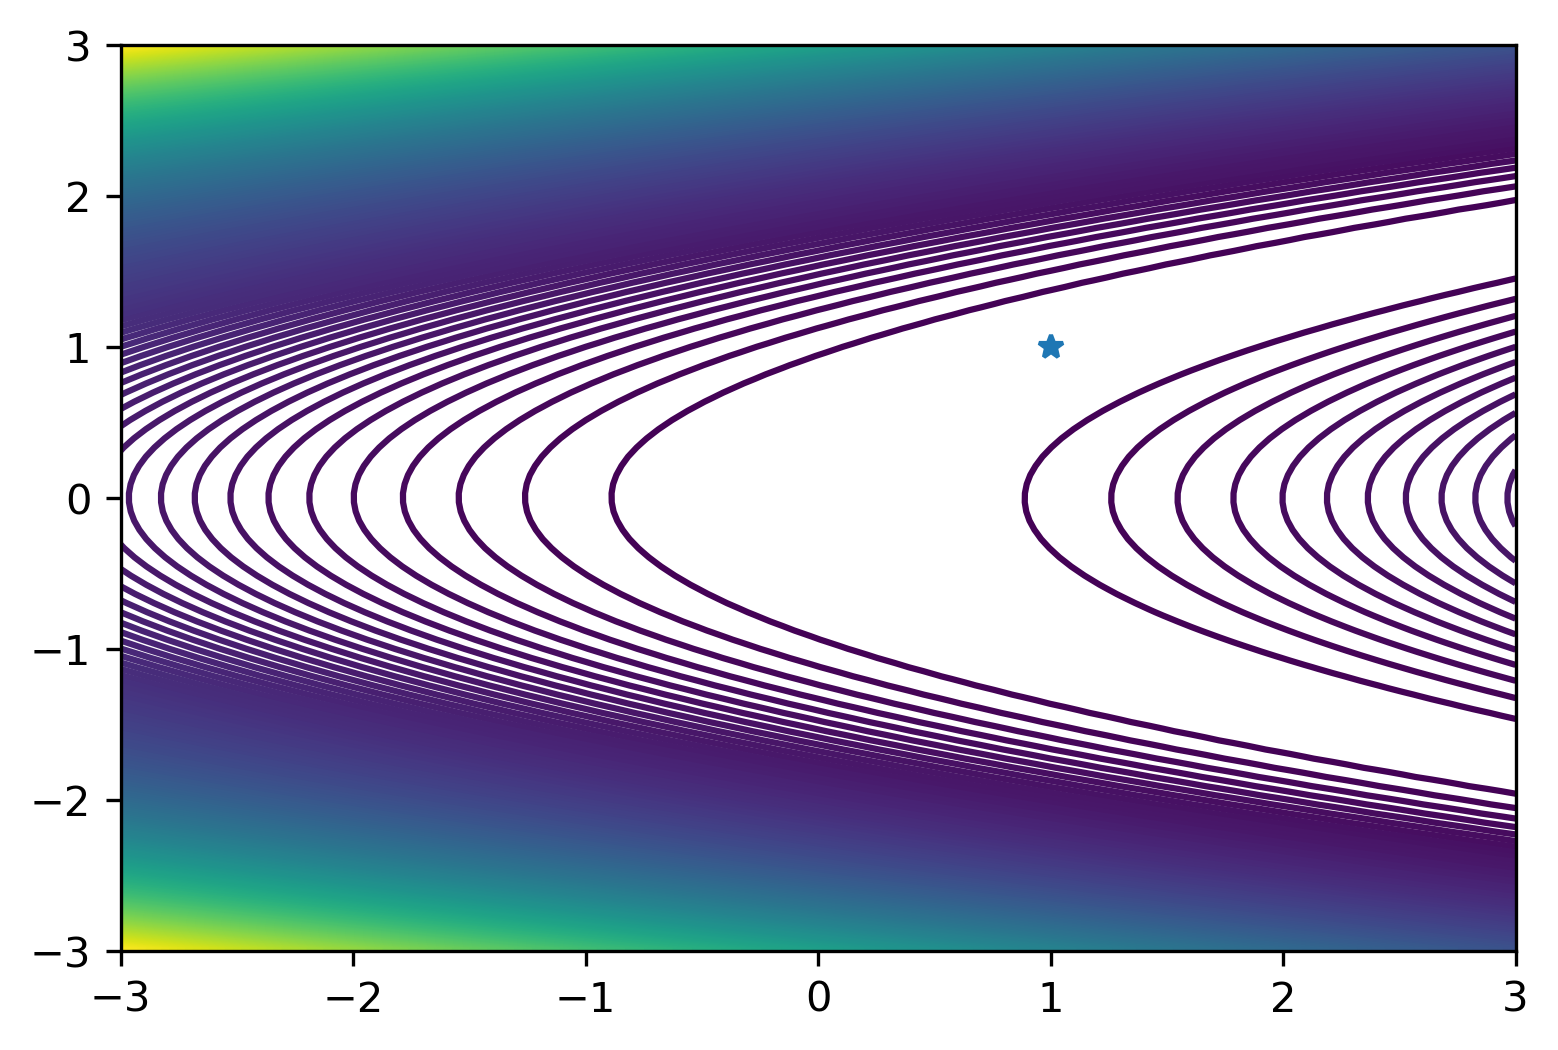

In [4]:
# plot of the Rosenbrock function
n = 100
x1 = np.linspace(-3,3,n)
x2 = np.linspace(-3,3,n)
xx1,xx2 = np.meshgrid(x1,x2)

xs = np.array([1,1])
fs = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        fs[i,j],_,_ = rosenbrock((x1[i],x2[j]))

plt.contour(xx1,xx2,fs,levels=200)
plt.plot(xs[0],xs[1],'*')

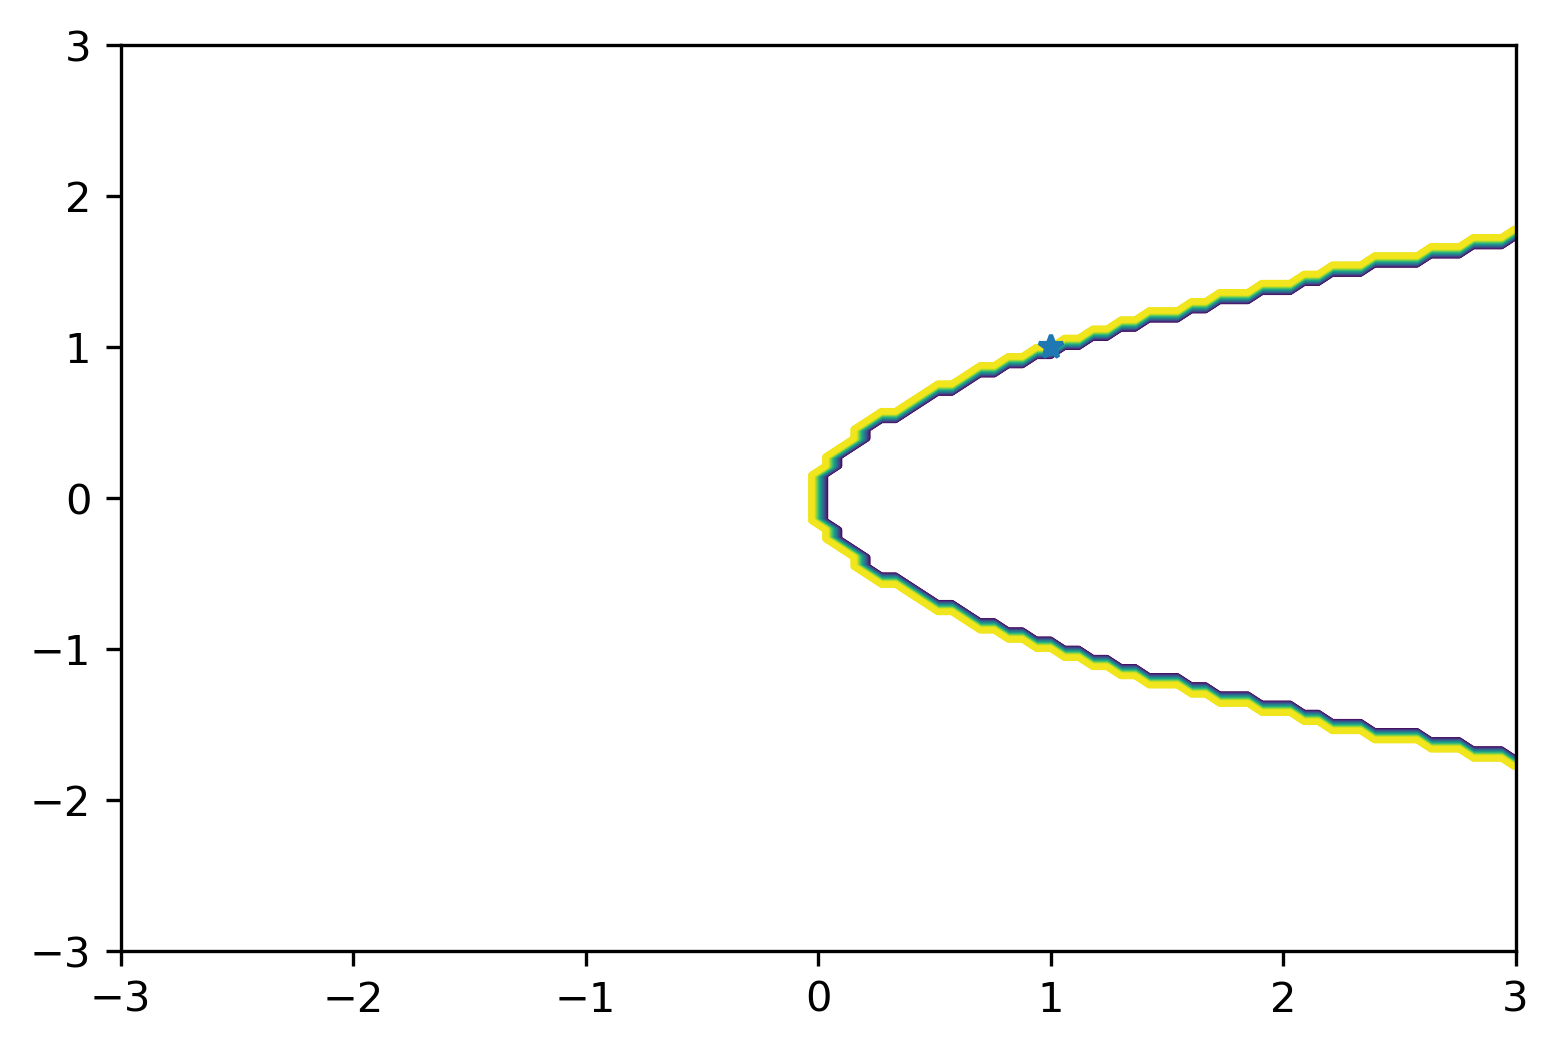

In [5]:
# determine region of convexity by computing eigenvalues of the Hessian
e1 = np.zeros((n,n))
e2 = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        _,_,Hs = rosenbrock((x1[i],x2[j]))
        e1[i,j],e2[i,j] = np.linalg.eigvals(Hs)

plt.contour(xx1,xx2,(e1>0)*(e2>0),levels=50)
plt.plot(xs[0],xs[1],'*')

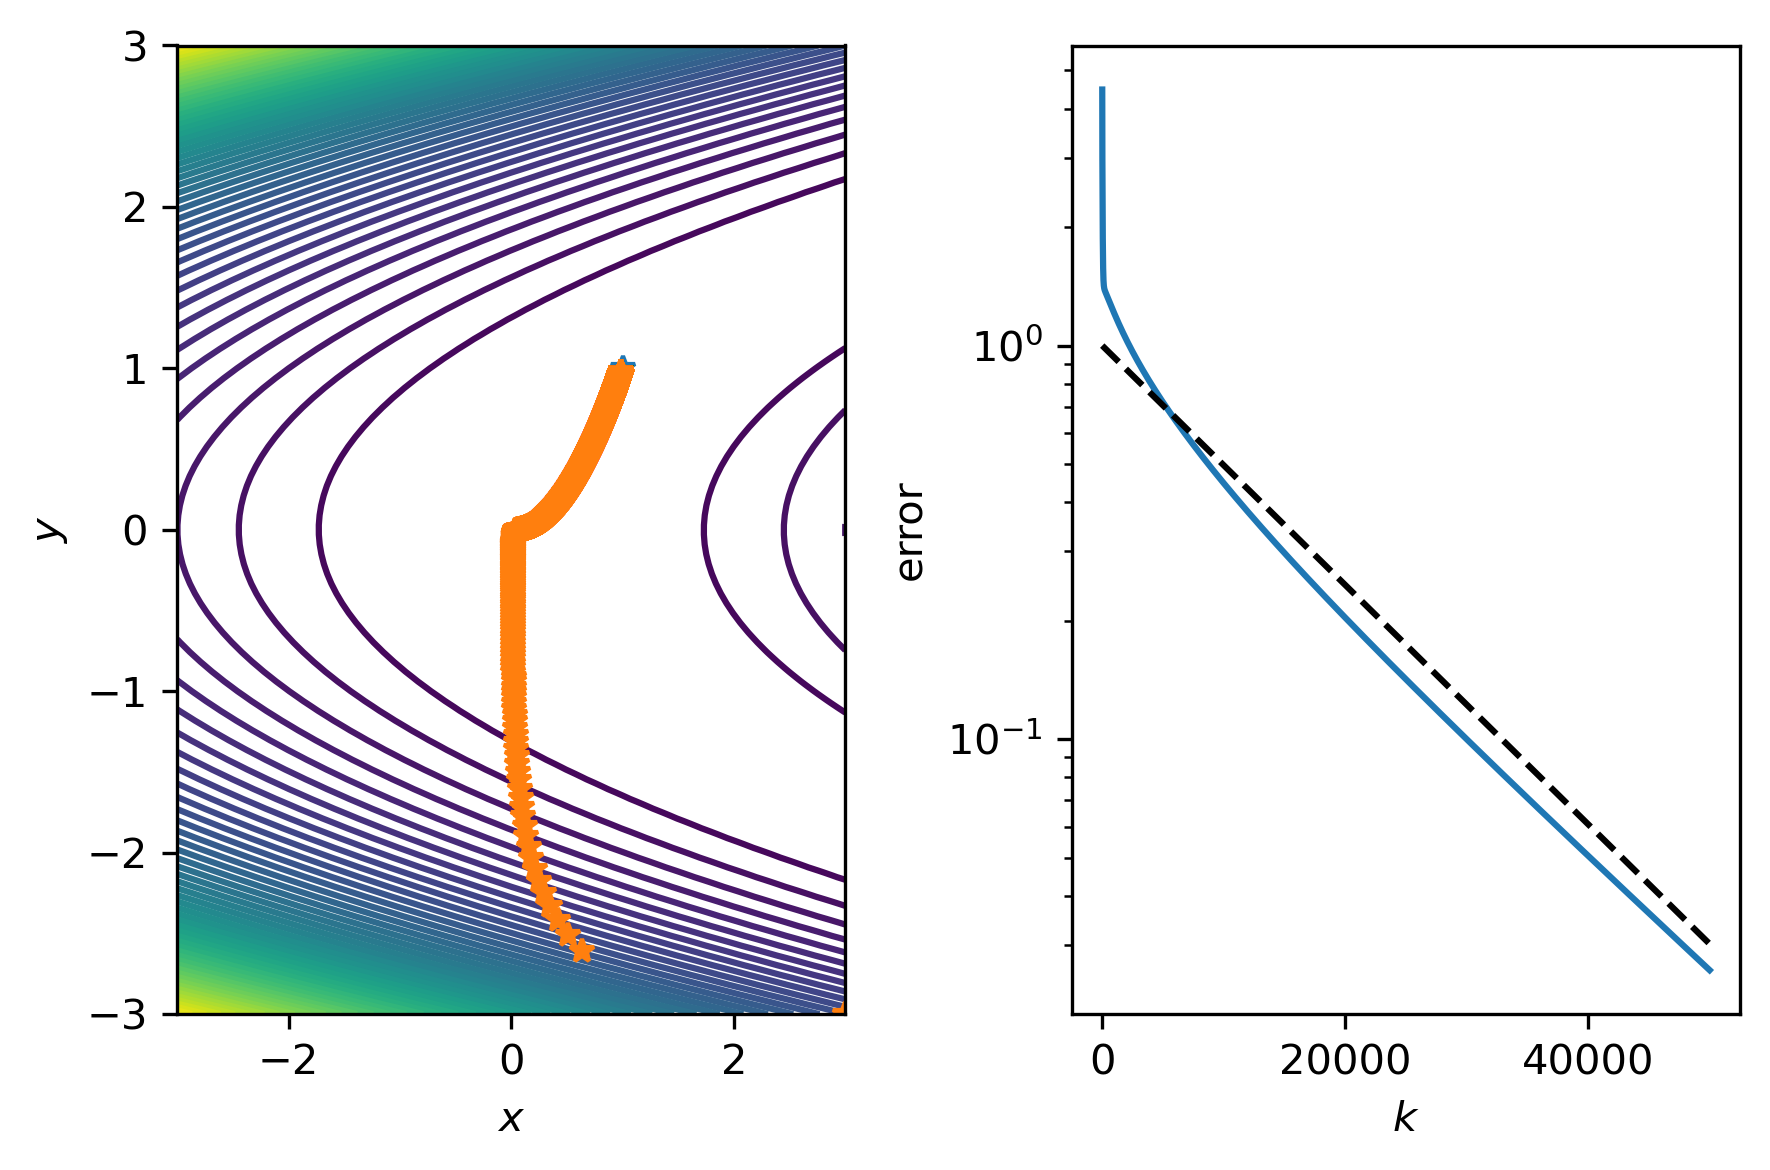

In [6]:
# run steepest descent
L = 12122
alpha = 1.99/L
maxiter = 50000

x = steep(rosenbrock, [3,-3],alpha,maxiter)

# plot
k = np.linspace(1,maxiter,maxiter)

fig,ax = plt.subplots(1,2)
ax[0].contour(xx1,xx2,fs,levels=50)
ax[0].plot(1,1,'*')
ax[0].plot(x[:,0],x[:,1],'*')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')

ax[1].semilogy(k,np.linalg.norm(x - xs,axis=1),k,(.99993)**k,'k--')
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel('error')

fig.tight_layout()
plt.show()

/opt/anaconda3/envs/jbook/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/envs/jbook/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


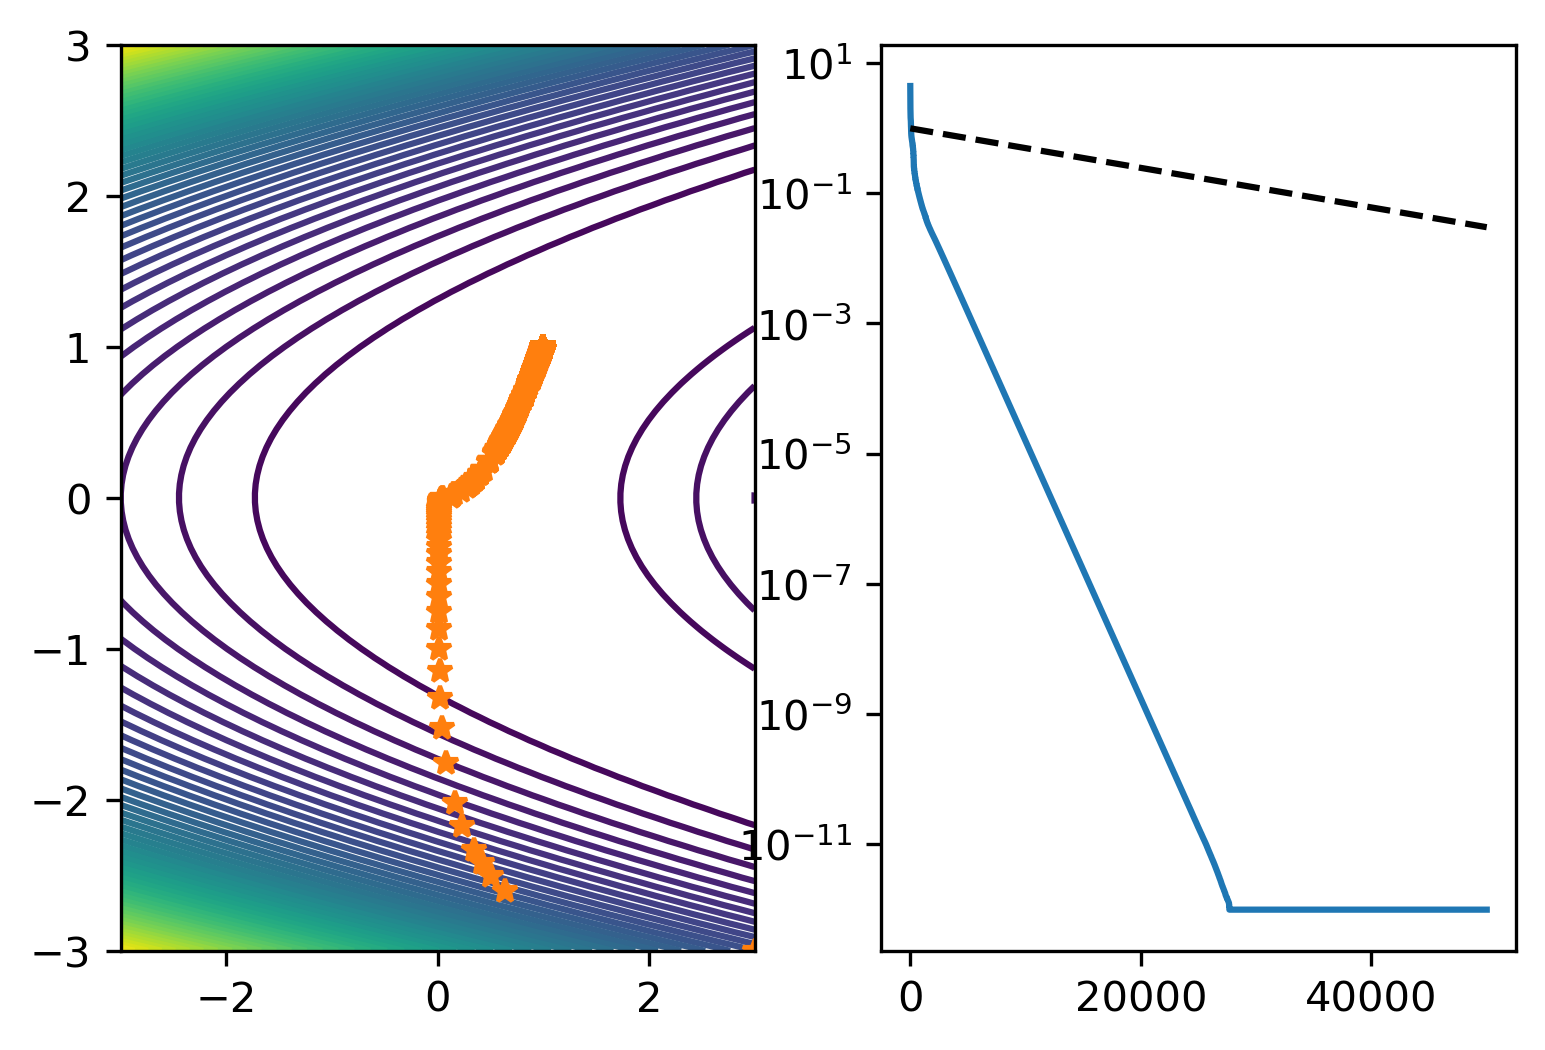

In [7]:
# run steepest descent with linesearch
L = 12122
alpha = 1.99/L
maxiter = 50000

x = steep_wolfe(rosenbrock, [3,-3],1.99/L,50000)

# plot
k = np.linspace(1,maxiter,maxiter)

fig,ax = plt.subplots(1,2)
ax[0].contour(xx1,xx2,fs,levels=50)
ax[0].plot(1,1,'*')
ax[0].plot(x[:,0],x[:,1],'*')
ax[1].semilogy(k,np.linalg.norm(x - xs,axis=1),k,(.99993)**k,'k--')

### Subdifferentials

Compute the subdifferentials of the following functionals $J : \mathbb{R}^n \rightarrow \mathbb{R}_+$:

* The Euclidean norm $J(u) = \|u\|_2$.
* The elastic net $J(u) = \alpha \|u\|_1 + \beta \|u\|_2^2$
* The weighted $\ell_1$-norm $J(u) = \|Du\|_1$, with $D \in \mathbb{R}^{m\times n}$ for $m < n$ a full-rank matrix.

```{admonition} Answer
:class: tip, dropdown

* When $\|u\|_2 \not=0$ we have $\partial J(u) = \{u/\|u\|_2\}$. Otherwise we have $\partial J(0) = \{g \in \mathbb{R}^n | \|g\|_2 \leq 1\}$. Indeed, we can check that for all $g \in \partial J(0)$ we have $\langle g,v\rangle \leq \|v\|_2$ for all $v \in \mathbb{R}^n$.

* An element $g$ of $\partial \|u\|_1$ has entries

$$g_i = \begin{cases} -1 & u_i < 0 \\ [-1,1] & u_i = 0 \\ 1 & u_i > 0\end{cases}.$$

For $\|u\|_2^2$ we have $\partial \|u\|_2^2 = {u}$. Combining gives

$$g_i = \begin{cases} -\alpha + \beta u_i & u_i < 0 \\ [-\alpha + \beta u_i,\alpha + \beta u_i] & u_i = 0 \\ \alpha + \beta u_i & u_i > 0\end{cases}.$$

* We get $\partial \|Du\|_1 =  \{D^Tg\}$, with $g$ given by

$$g_i = \begin{cases} -1 & v_i < 0 \\ [-1,1] & v_i = 0 \\ 1 & v_i > 0\end{cases},$$

where $v = Du$.
```

### Dual problems

Derive the dual problems for the following optimization problems

* $\min_u \|u - f^\delta\|_1 + \lambda \|u\|_2^2$.
* $\min_u \textstyle{\frac{1}{2}}\|u - f^\delta\|_2^2 + \lambda \|u\|_p, \quad p \in \mathbb{N}_{>0}$.
* $\min_{u \in [-1,1]^n} \textstyle{\frac{1}{2}}\|u - f^\delta\|_2^2$.

```{admonition} Answer
:class: tip, dropdown

* We end up with having to solve $\min_u \|u-f\|_1 + \langle \nu,u\rangle$ and $\min_v \lambda \|v\|_2^2 - \langle \nu, v \rangle$. For the first, we note that the optimal value tends to $- \infty$ when $\|\nu\|_{\infty} > 1$. For $\|\nu\|_{\infty} \leq 1$ the minimum is attained at $u = f$, giving $\langle \nu,f\rangle$.
The second one is easy, since we can compute the optimality condition easily: $2\lambda v - \nu = 0$ giving $v = (2\lambda)^{-1}\nu$ which leads to $-(4\lambda)^{-1}\|\nu\|_2^2$. We end up with

$$\max_{\nu} \langle \nu,f \rangle - (4\lambda)^{-1}\|\nu\|_2^2 \quad \text{s.t.} \quad \|\nu\|_{\infty} \leq 1.$$

In terms of the optimal solution this is equivalent to

$$\min_{\nu} \textstyle{\frac{1}{2}}\|\nu - 2\lambda f\|_2^2 \quad \text{s.t.} \quad \|\nu\|_{\infty} \leq 1.$$

* From $\min_{u} \textstyle{\frac{1}{2}}\|u - f^\delta\|_2^2 + \langle \nu,u\rangle$ we get $-\textstyle{\frac{1}{2}}\|\nu\|_2^2 + \langle \nu,f^\delta\rangle$. From $\min_{v} \lambda \|v\|_p - \langle \nu,v\rangle$ we get the constraint $\|\nu\|_{q}\leq \lambda$ with $p^{-1} + q^{-1} = 1$ (follows from Hölder's inequality). Using $\min_{v} \lambda \|v\|_p - \langle \nu,v\rangle$ when $\|\nu\|_{q}\leq \lambda$, we obtain

$$\max_{\nu} -\textstyle{\frac{1}{2}}\|\nu\|_2^2 + \langle \nu,f^\delta\rangle \quad \text{s.t.} \quad \|\nu\|_q \leq \lambda,$$

 which in terms of the optimal solution is equivalent to


 $$\min_{\nu} \textstyle{\frac{1}{2}}\|\nu - f^\delta\|_2^2 \quad \text{s.t.} \quad \|\nu\|_q \leq 1.$$

 * Given a function $\delta_A$ such that $\delta_A(x)=0$ if $x\in A$ and $\delta_A(x)=\infty$ if $x \notin A$, the saddle-point problem is

 $$\max_{\nu} \min_{u\in\mathbb{R}^n} \textstyle{\frac{1}{2}}\|u - f^\delta\|_2^2 + \langle \nu,u \rangle + \min_v \delta_{[-1,1]^n}(v) - \langle \nu,v\rangle.$$

The first part is the same as the previous one. The second attains its minimum at $v_i = \text{sign}(\nu_i)$ which yields $-\|\nu\|_1$. Thus the dual problem is

$$\max_{\nu} -\textstyle{\frac{1}{2}}\|\nu\|_2^2 + \langle \nu,f^\delta\rangle - \|\nu\|_1,$$

which in terms of the optimal solution is equivalent to

$$\min_{\nu} \textstyle{\frac{1}{2}}\|\nu - f^\delta\|_2^2 + \|\nu\|_1.$$
```

### TV-denoising

In this exercise we consider a one-dimensional TV-denoising problem

$$\min_{\mathbb{R}^n} \textstyle{\frac{1}{2}} \|u - f^\delta\|_2^2 + \lambda \|Du\|_1,$$

with $D$ a first-order finite difference discretization of the first derivative.


* Show that the problem is equivalent (in terms of solutions) to solving

$$\min_{\nu} \textstyle{\frac{1}{2}}\|D^*\nu - f^\delta\|_2^2 \quad \text{s.t.} \quad \|\nu\|_{\infty} \leq \lambda.$$

* Implement a proximal-gradient method for solving the dual problem.

* Implement an ADMM method for solving the (primal) denoising problem.

* Test and compare both methods on a noisy signal. Example code is given below.

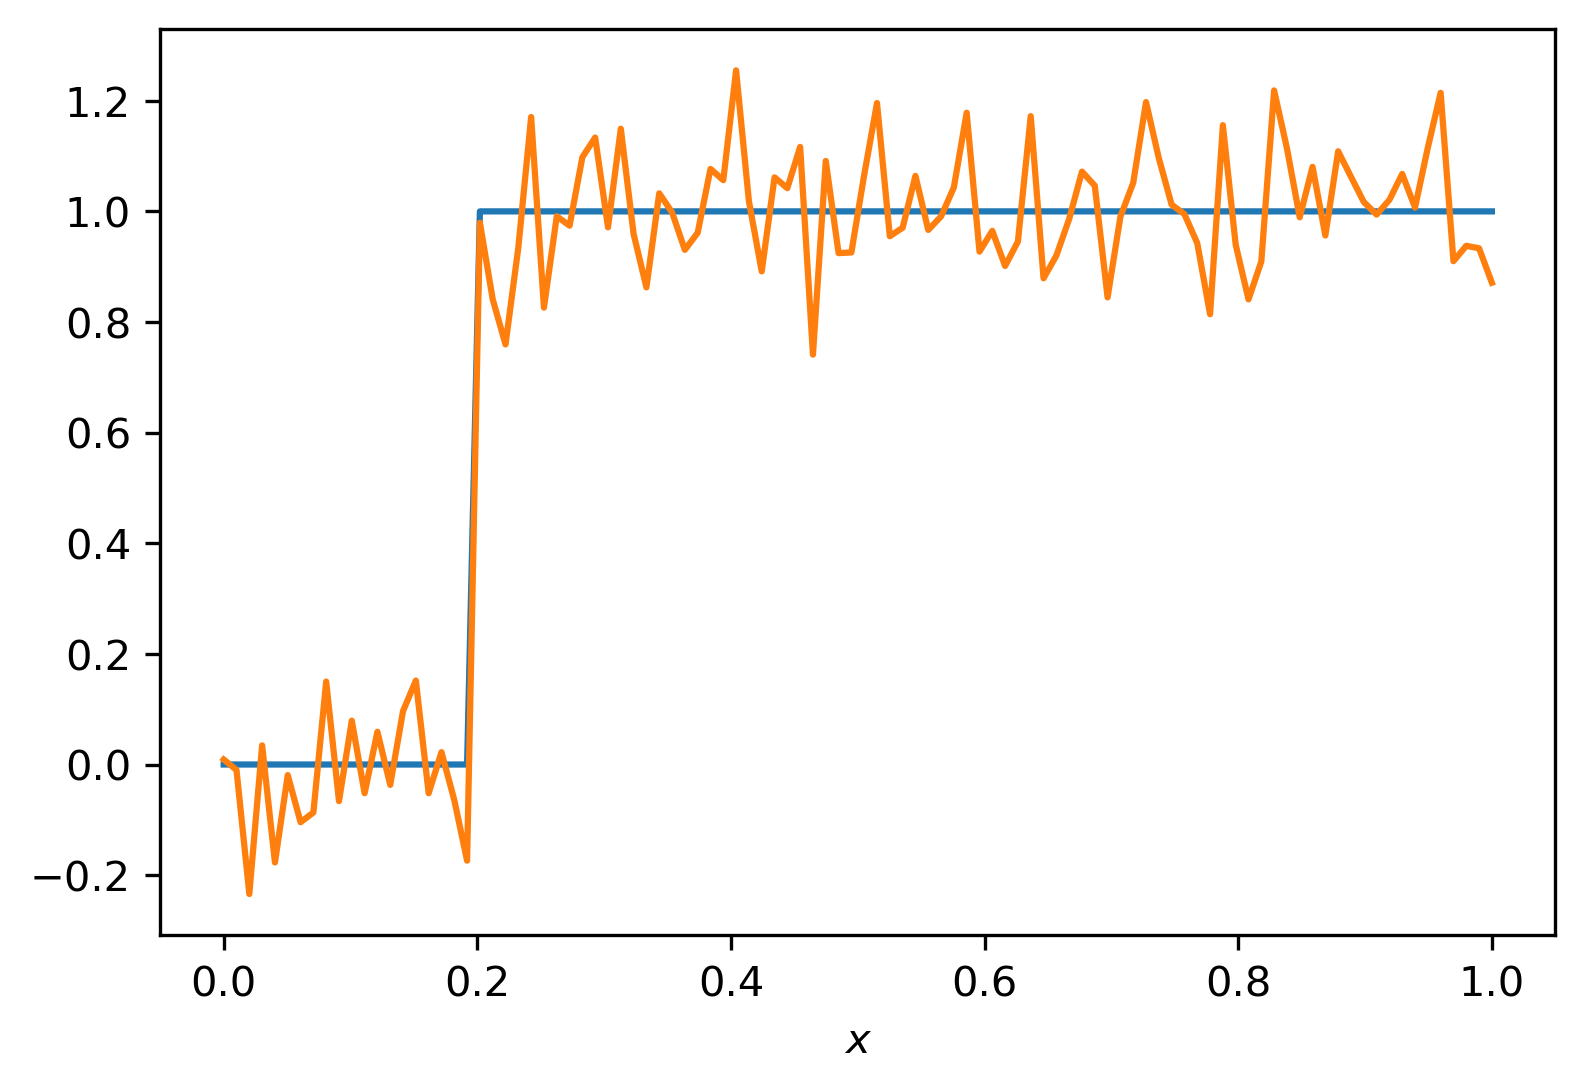

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# grid \Omega = [0,1]
n = 100
h = 1/(n-1)
x = np.linspace(0,1,n)

# parameters
sigma = 1e-1

# make data
u = np.heaviside(x - 0.2,0)
f_delta = u + sigma*np.random.randn(n)

# FD differentiation matrix
D = (np.diag(np.ones(n-1),1) - np.diag(np.ones(n),0))/h

# plot
plt.plot(x,u,x,f_delta)
plt.xlabel(r'$x$')
plt.show()

````{admonition} Answer
:class: tip, dropdown

* The saddle-point problem is

$$\max_{\nu} \min_{u} \textstyle{\frac{1}{2}}\|u - f^\delta\|_2^2 + \langle \nu,Du\rangle + \min_v \lambda \|v\|_1 - \langle \nu,v\rangle.$$

See the example and previous exercise for details.

* The basic iteration for proximal-gradient is

$$\nu_{k+1} = \Pi_{\lambda} \left(\nu_k - \alpha D(D^*\nu_k - f^\delta)\right),$$

with

$$\Pi_{\lambda}(v)_i = \begin{cases} v_i & |v_i| \leq \lambda \\ \lambda \text{sign}(v_i) & |v_i| > \lambda \end{cases}.$$

* The basic iteration for ADMM is

$$u_{k+1} = \left(I + \rho D^*\!D\right)^{-1}\left(f^\delta + D^*(\rho v_k - \nu_k)\right).$$
$$v_{k+1} = \text{prox}_{(\lambda/\rho)\|\cdot\|_1}\left(Du_{k+1} + \rho^{-1}\nu_k\right).$$
$$\nu_{k+1}= \nu_k + \rho \left(Du_{k+1} - v_{k+1}\right).$$

* Below we see results for both methods using $\lambda = 5\cdot 10^{-3}$, $\alpha = 1/\|D\|^2$, $\rho = 1$. Both methods give comparable results and exhibit very similar convergence behaviour.

```{glue:figure} TV_exercise
:figwidth: 500px
:name: "TV_exercise"

Results for TV denoising using the proximal gradient method and ADMM.
```
````

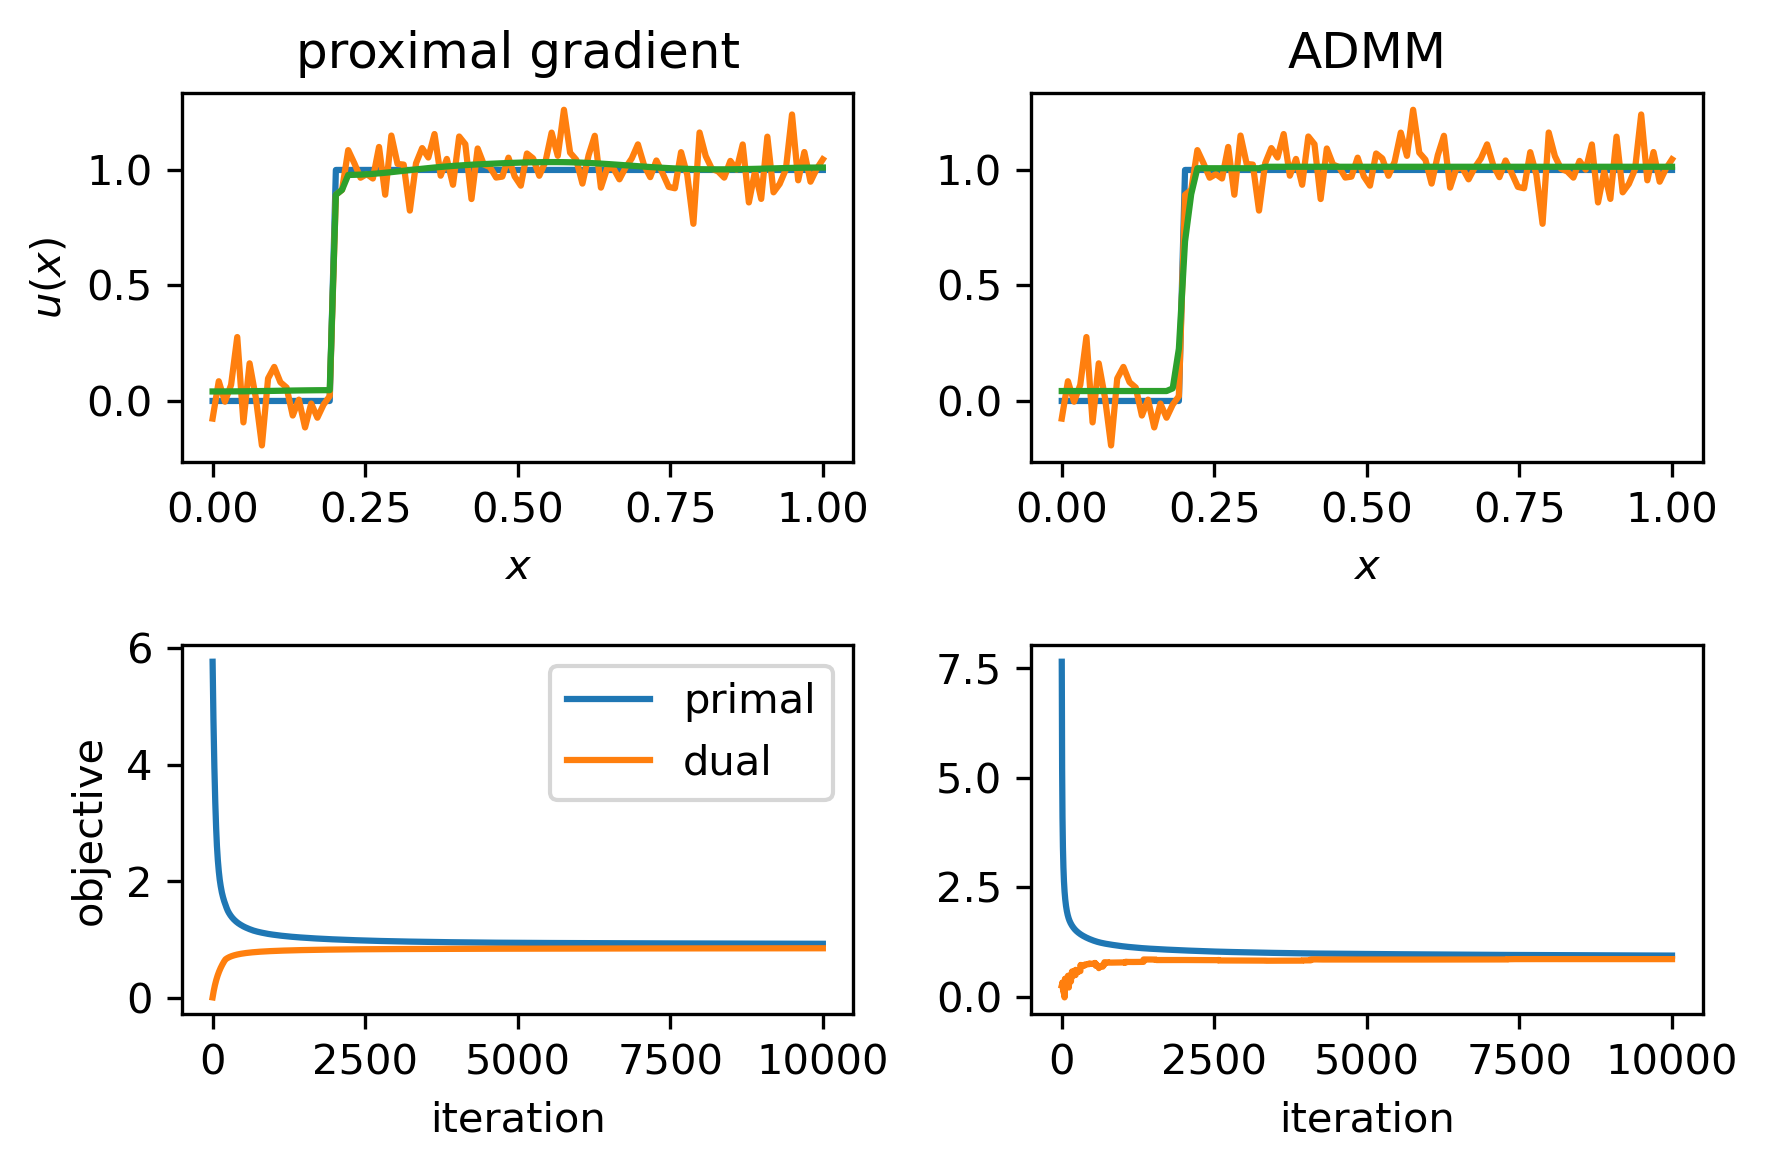

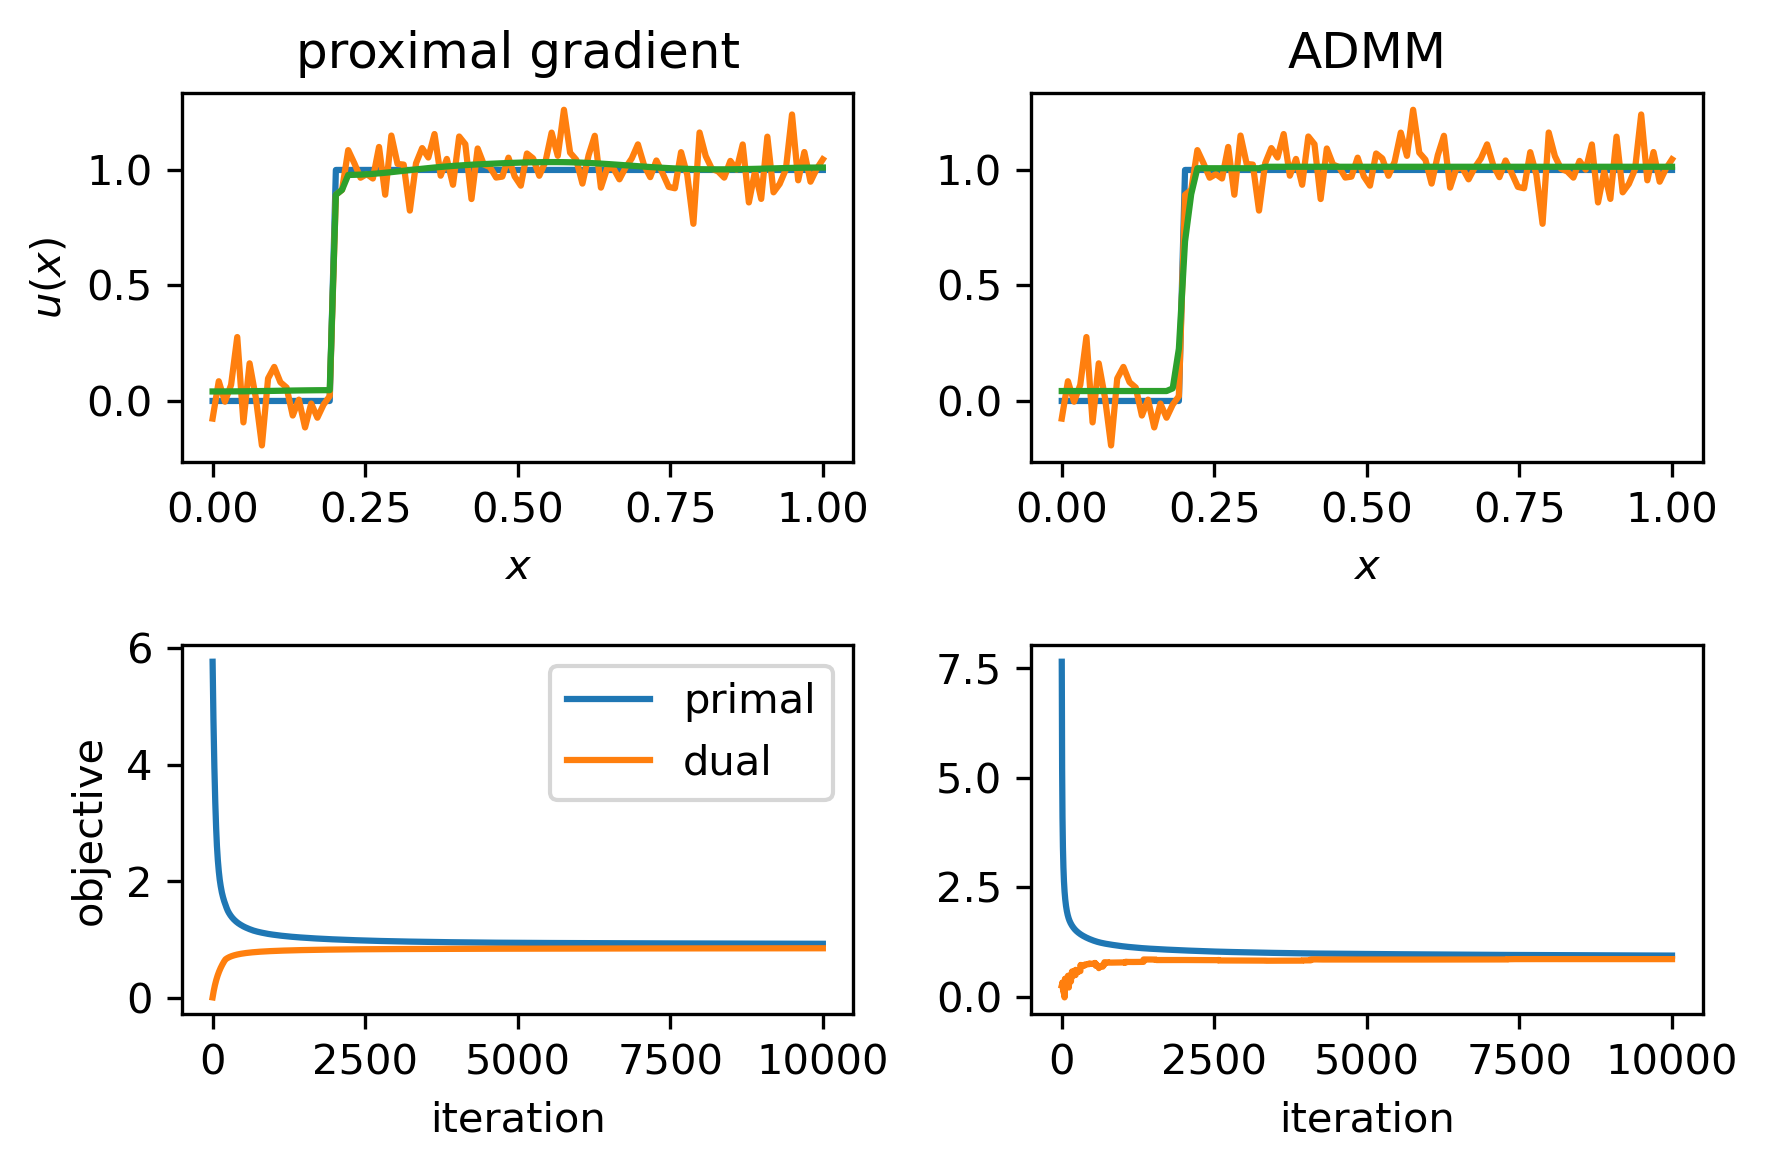

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from myst_nb import glue

def prox_grad(f,lmbda,D,alpha,niter):
    nu = np.zeros(D.shape[0])
    hist = np.zeros((niter,2))

    P = lambda nu : np.piecewise(nu, [np.abs(nu) <= lmbda, np.abs(nu) > lmbda], [lambda x : x, lambda x : lmbda*np.sign(x)])

    for k in range(0,niter):
        nu = P(nu - alpha*D@(D.T@nu - f))
        u = f - D.T@nu
        primal = 0.5*np.linalg.norm(u - f)**2 + lmbda*np.linalg.norm(D@u,ord=1)
        dual = -0.5*np.linalg.norm(D.T@nu) + f.dot(D.T@nu)
        hist[k] = primal, dual

    return u, hist

def admm(f,lmbda,D,rho,niter):
    m,n = D.shape
    nu = np.zeros(m)
    v = np.zeros(m)
    u = np.zeros(n)
    hist = np.zeros((niter,2))

    T = lambda v : np.piecewise(v, [v < -lmbda/rho, np.abs(v) <= lmbda/rho, v > lmbda/rho], [lambda x : x + lmbda/rho, lambda x : 0, lambda x : x - lmbda/rho])

    for k in range(0,niter):
        u = np.linalg.solve(np.eye(n) + rho*D.T@D, f + D.T@(rho*v - nu))
        v = T(D@u + nu/rho)
        nu = nu + rho*(D@u - v)

        primal = 0.5*np.linalg.norm(u - f)**2 + lmbda*np.linalg.norm(D@u,ord=1)
        dual = -0.5*np.linalg.norm(D.T@nu) + f.dot(D.T@nu)
        hist[k] = primal, dual

    return u, hist

# grid \Omega = [0,1]
n = 100
h = 1/(n-1)
x = np.linspace(0,1,n)

# parameters
sigma = 1e-1
niter = 10000
lmbda = 5e-3

# make data
u = np.heaviside(x - 0.2,0)
f_delta = u + sigma*np.random.randn(n)

# FD differentiation matrix
D = (np.diag(np.ones(n-1),1)[:-1,:] - np.diag(np.ones(n),0)[:-1,:])/h

# proximal gradient on dual problem
alpha = 1/np.linalg.norm(D)**2
u_prox, hist_prox = prox_grad(f_delta,lmbda,D,alpha,niter)

# ADMM
rho = 1
u_admm, hist_admm = admm(f_delta,lmbda,D,rho,niter)

# plot
fig,ax = plt.subplots(2,2)

ax[0,0].set_title('proximal gradient')
ax[0,0].plot(x,u,x,f_delta,x,u_prox)
ax[0,0].set_xlabel(r'$x$')
ax[0,0].set_ylabel(r'$u(x)$')

ax[1,0].plot(hist_prox[:,0],label='primal')
ax[1,0].plot(hist_prox[:,1],label='dual')
ax[1,0].legend()
ax[1,0].set_xlabel('iteration')
ax[1,0].set_ylabel('objective')

ax[0,1].set_title('ADMM')
ax[0,1].plot(x,u,x,f_delta,x,u_admm)
ax[0,1].set_xlabel(r'$x$')
ax[1,1].plot(hist_admm[:,0],label='primal')
ax[1,1].plot(hist_admm[:,1],label='dual')
ax[1,1].set_xlabel('iteration')

fig.tight_layout()

glue("TV_exercise",fig)

## Assignments

### Spline regularisation

The aim is to solve the following variational problem

$$\min_u \frac{1}{2} \|Ku - f^{\delta}\|_2^2 + \alpha \|Lu\|_1,$$

where $K$ is a given forward operator (matrix) and $L$ is a discretization of the second derivative operator.

1. Design and implement a method for solving this variational problem; you can be creative here -- multiple answers are possible
2. Compare your method with the basic subgradient-descent method implemented below
3. (bonus) Find a suitable value for $\alpha$ using the discrepancy principle

Some code to get you started is shown below.

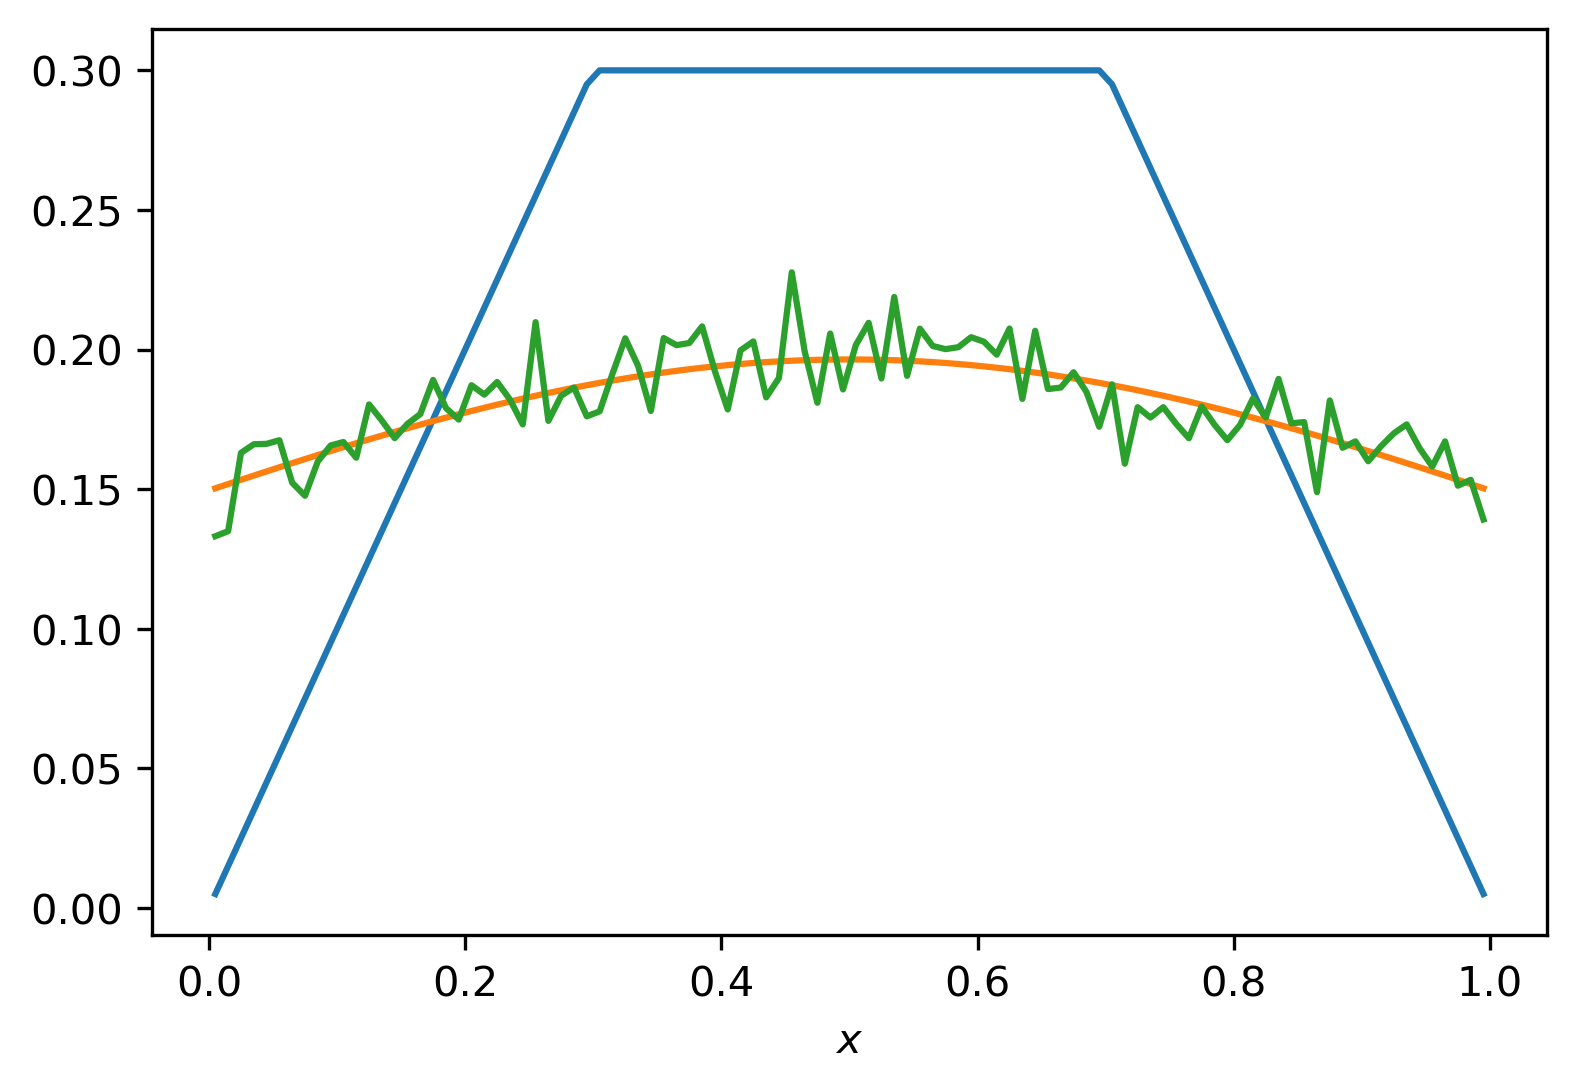

In [10]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# forward operator
def getK(n):
    h = 1/n;
    x = np.linspace(h/2,1-h/2,n)
    xx,yy = np.meshgrid(x,x)
    K = h/(1 + (xx - yy)**2)**(3/2)

    return K,x

# define regularization operator
def getL(n):
    h = 1/n;
    L = (np.diag(np.ones(n-1),-1) - 2*np.diag(np.ones(n),0) + np.diag(np.ones(n-1),1))/h**2
    return L

# define grid and operators
n = 100
delta = 1e-2
K,x = getK(n)
L = getL(n)

# true solution and corresponding data
u = np.minimum(0.5 - np.abs(0.5-x),0.3 + 0*x)
f = K@u

# noisy data
noise = np.random.randn(n)
f_delta = f + delta*noise

# plot
plt.plot(x,u,x,f,x,f_delta)
plt.xlabel(r'$x$')
plt.show()

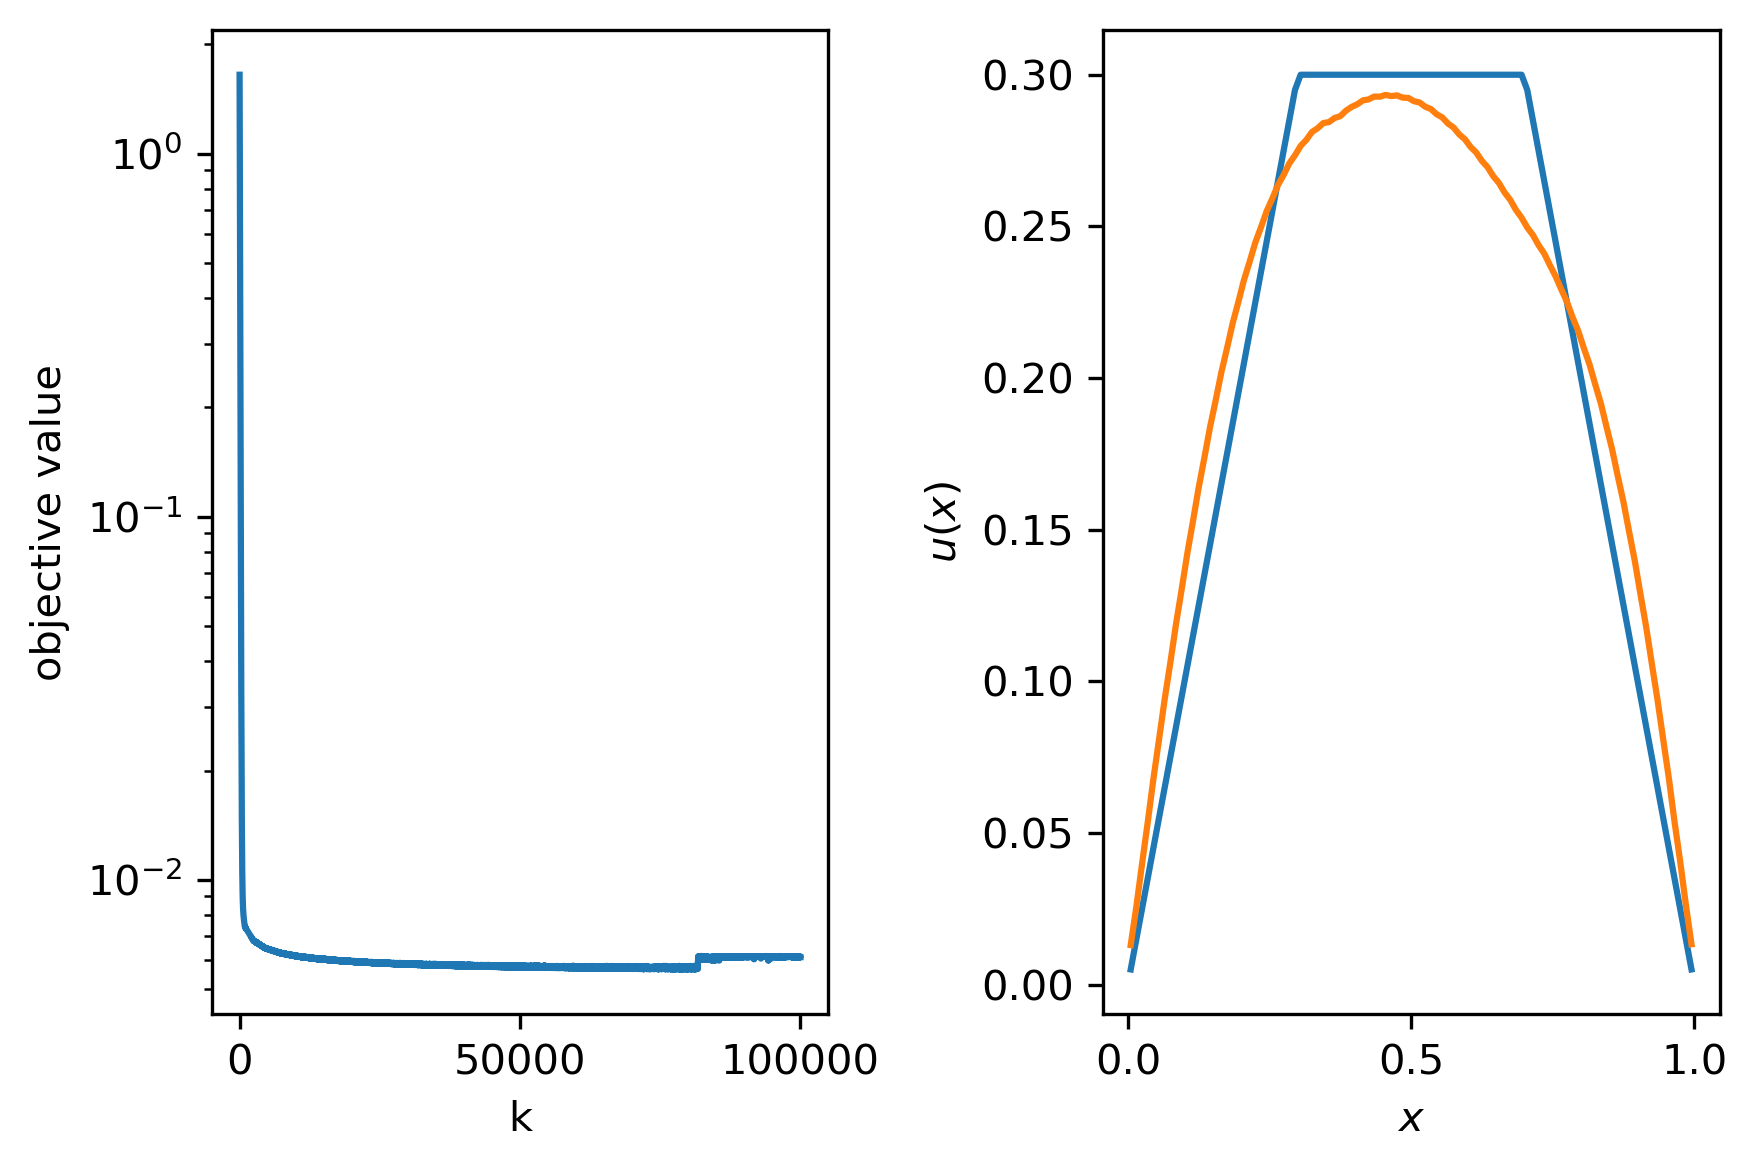

In [11]:
# example implementation of subgradient-descent
def subgradient(K, f_delta, alpha, L, t, niter):
    n = K.shape[1]
    u = np.zeros(n)
    objective = np.zeros(niter)
    for k in range(niter):
        # keep track of function value
        objective[k] = 0.5*np.linalg.norm(K@u - f_delta,2)**2 + alpha*np.linalg.norm(L@u,1)
        # compute (sub) gradient
        gr = (K.T@(K@u - f_delta) + alpha*L.T@np.sign(L@u))
        # update with stepsize t
        u = u - t*gr
    return u, objective

# get data
n = 100
delta = 1e-2

K,x = getK(n)
L = getL(n)

u = np.minimum(0.5 - np.abs(0.5-x),0.3 + 0*x)
f_delta = K@u + delta*noise

# parameters
alpha = 1e-6
niter = 100000
t = 1e-2

# run subgradient descent
uhat, objective = subgradient(K, f_delta, alpha, L, t, niter)

# plot
fig,ax = plt.subplots(1,2)

ax[0].semilogy(objective)
ax[0].set_xlabel('k')
ax[0].set_ylabel('objective value')

ax[1].plot(x,u,label='ground truth')
ax[1].plot(x,uhat,label='reconstruction')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u(x)$')

fig.tight_layout()